In [23]:
from Networks import *
import random

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# **DBLP**

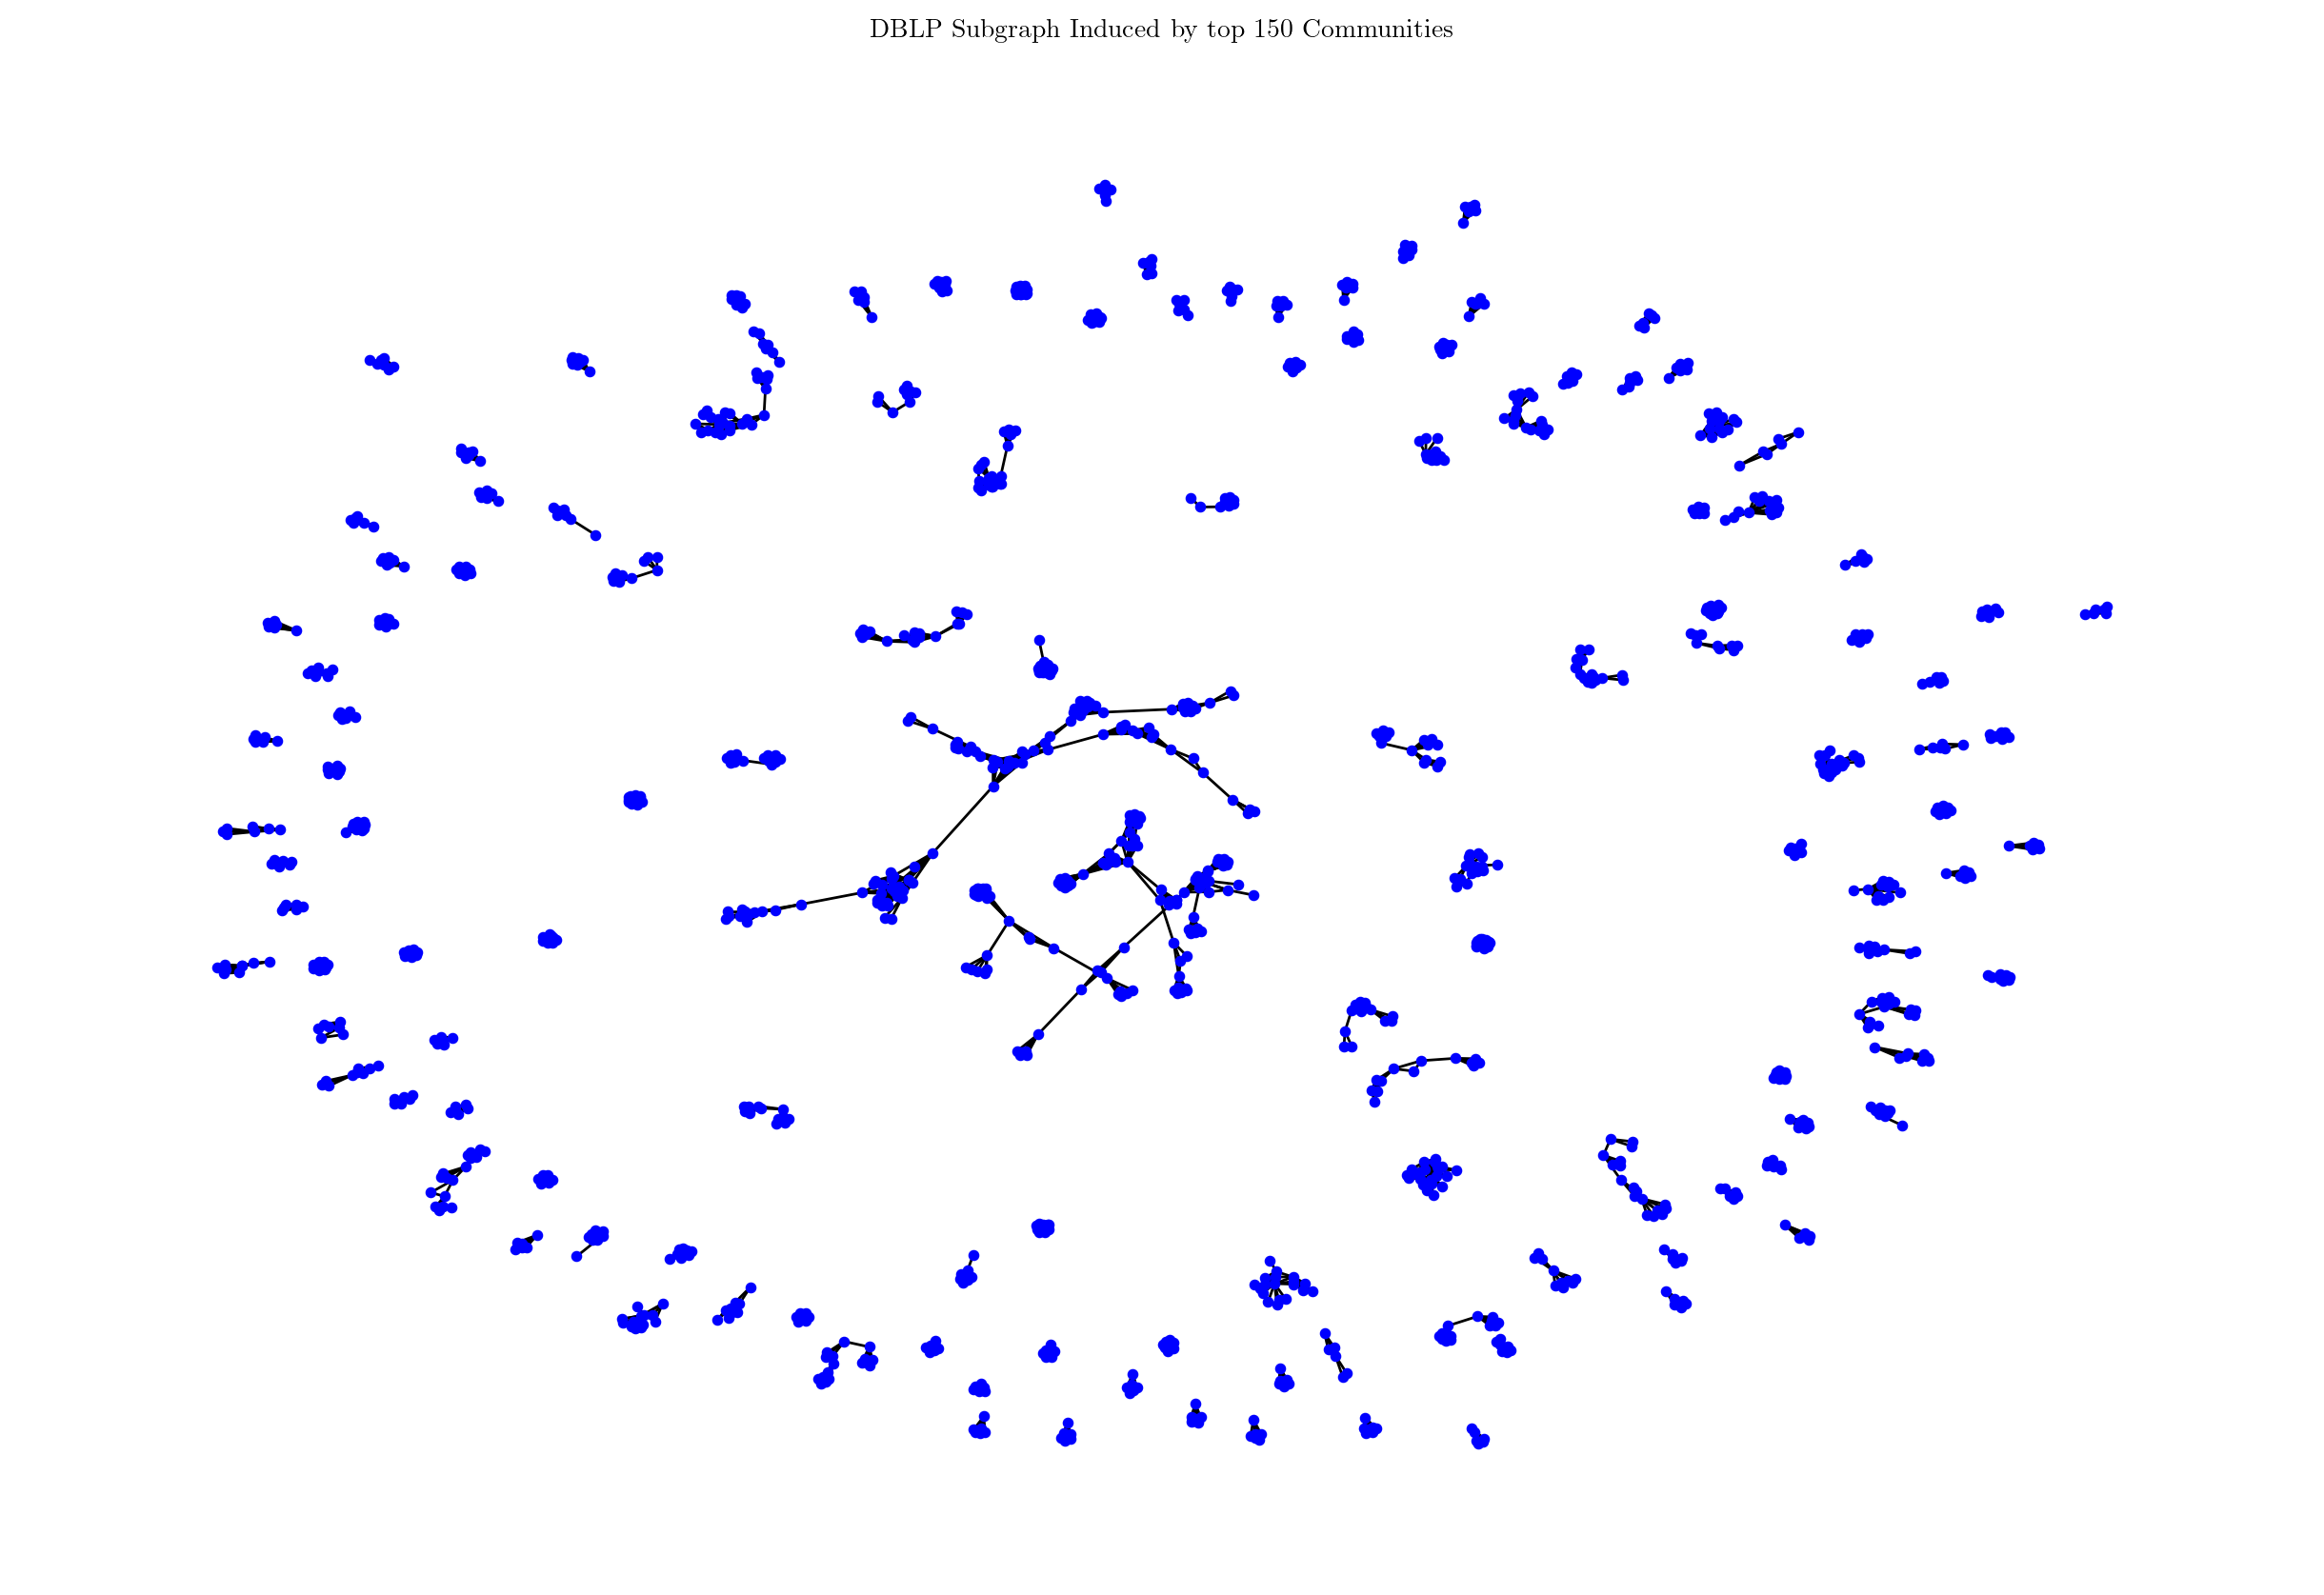

In [5]:
plt.figure(figsize = (12, 8))
nx.draw(G_ind_DBLP, with_labels = False, node_size = 10, node_color = "blue", edge_color = "black", pos = nx.spring_layout(G_ind_DBLP, scale = 4))
plt.title("DBLP Subgraph Induced by top 150 Communities")
plt.show()

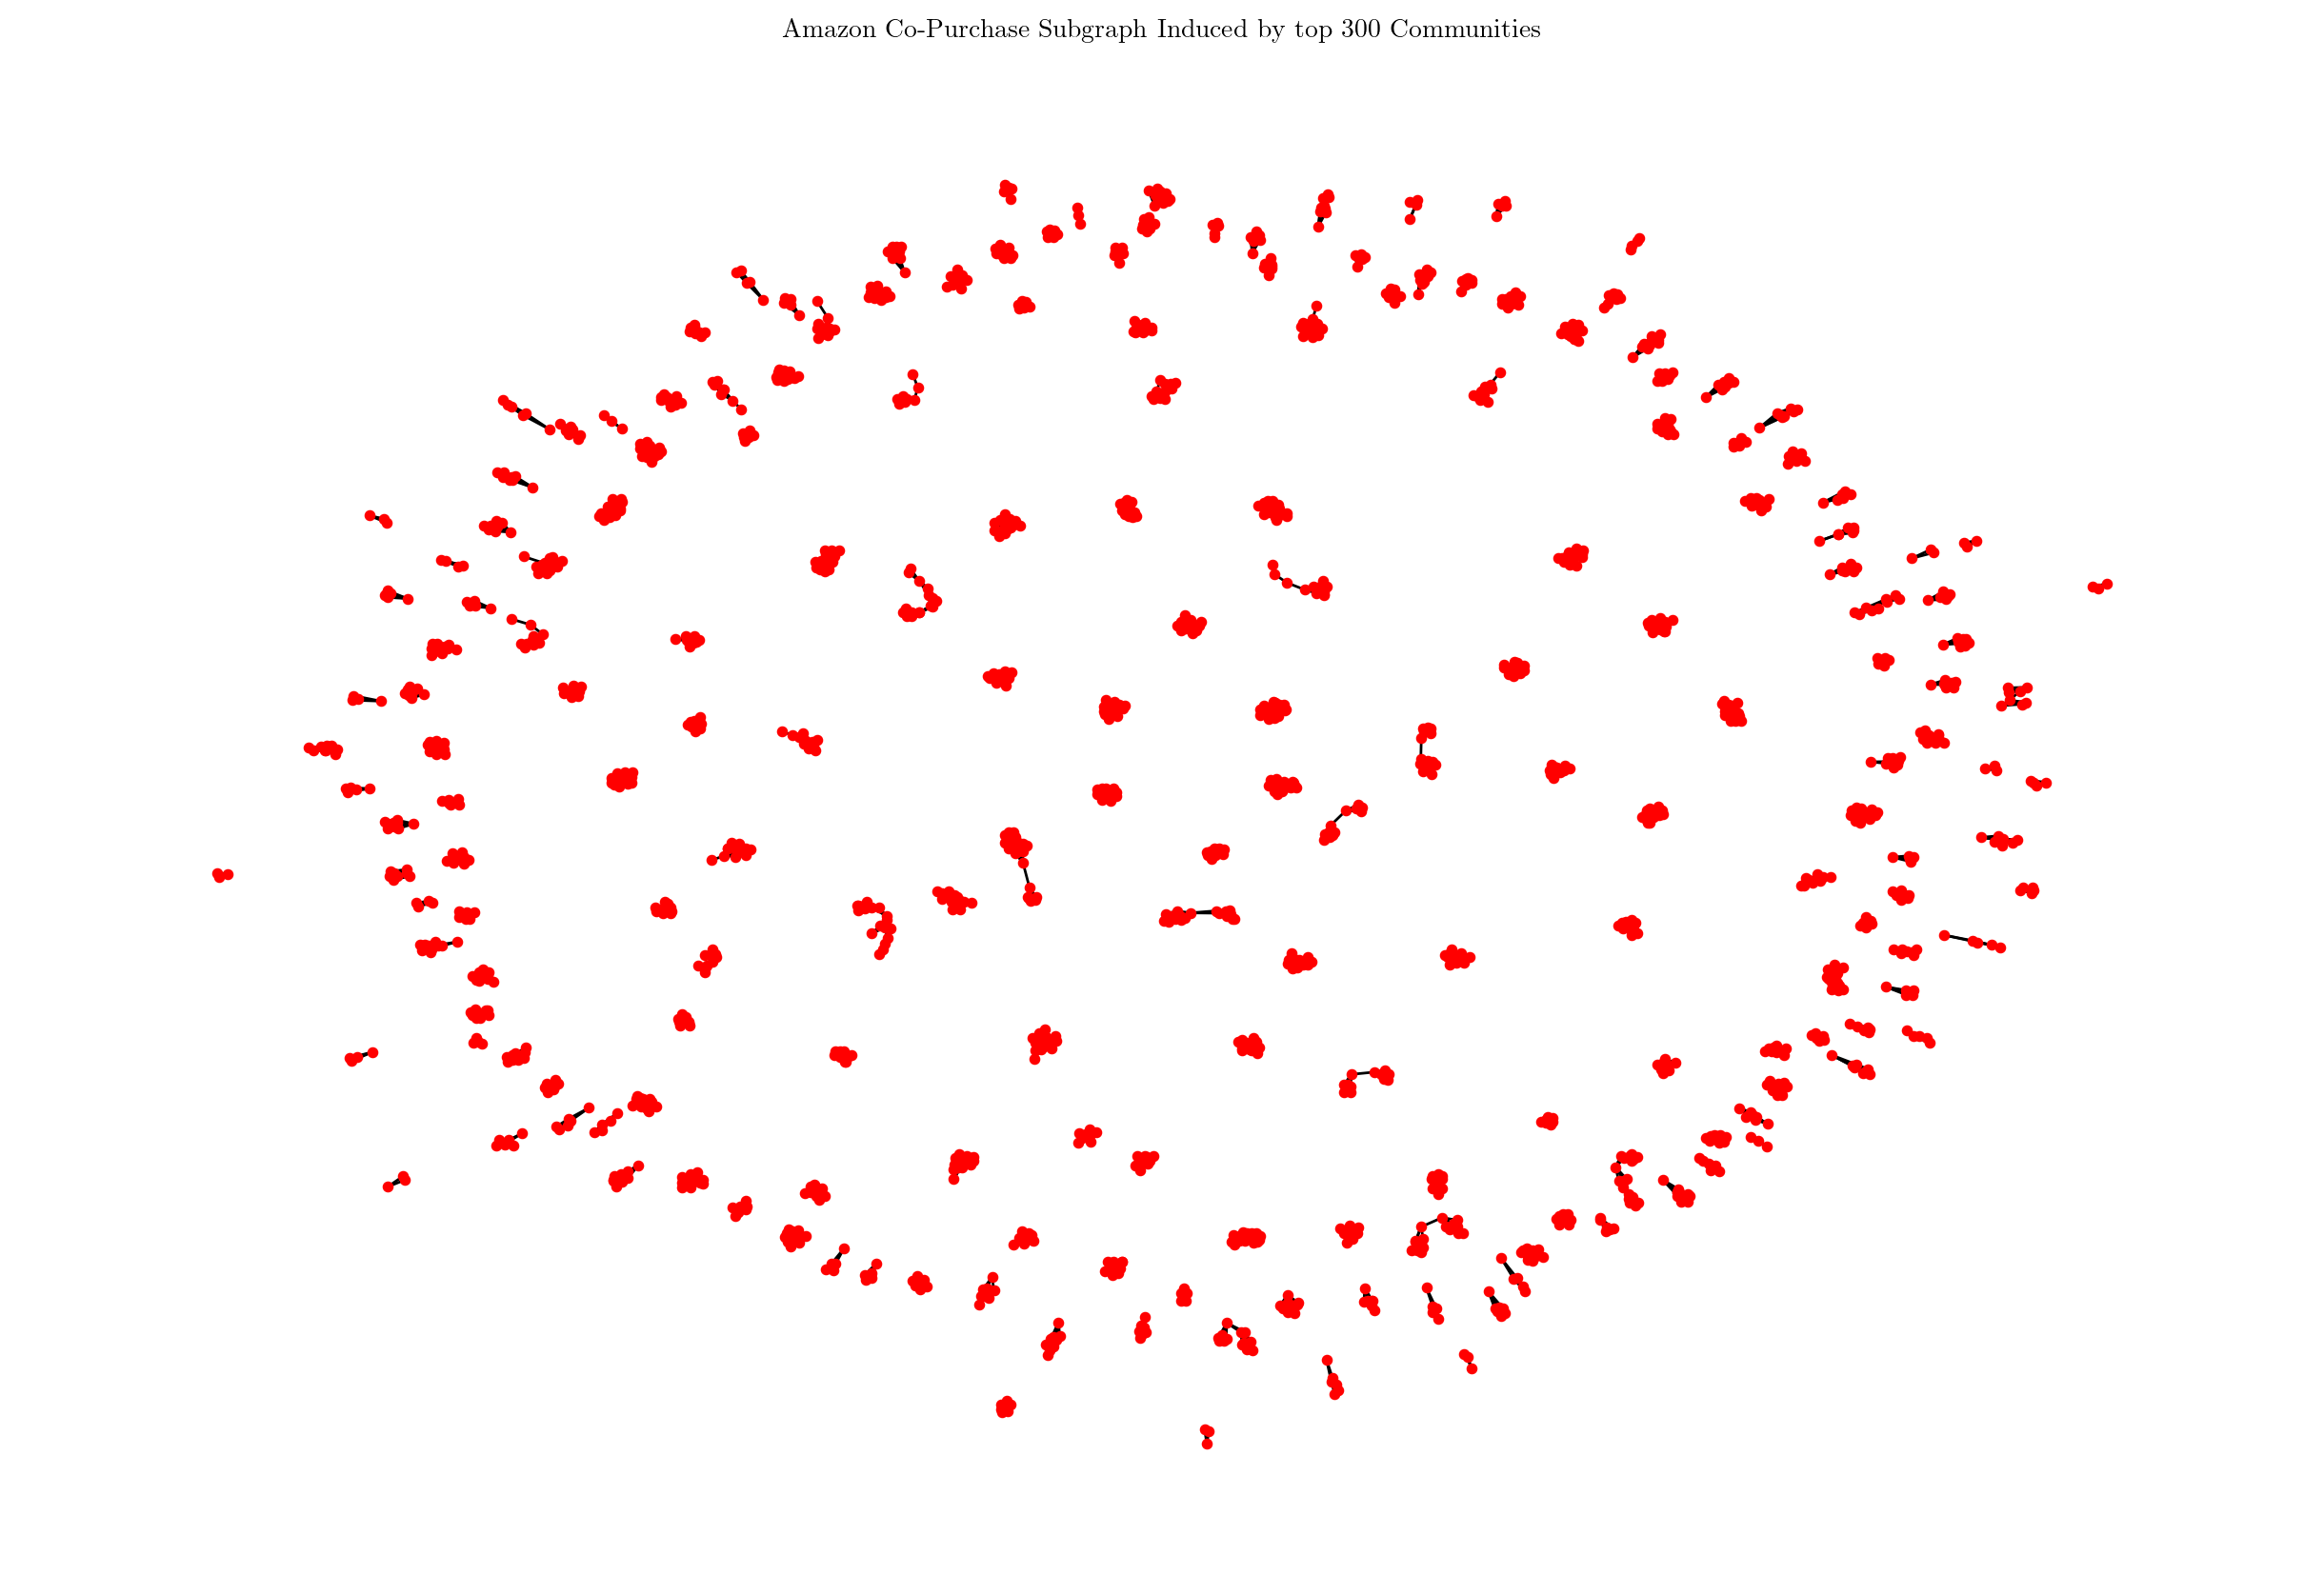

In [6]:
plt.figure(figsize = (12, 8))
nx.draw(G_ind_Amz, with_labels = False, node_size = 10, node_color = "red", edge_color = "black", pos = nx.spring_layout(G_ind_Amz, scale = 4))
plt.title("Amazon Co-Purchase Subgraph Induced by top 300 Communities")
plt.show()

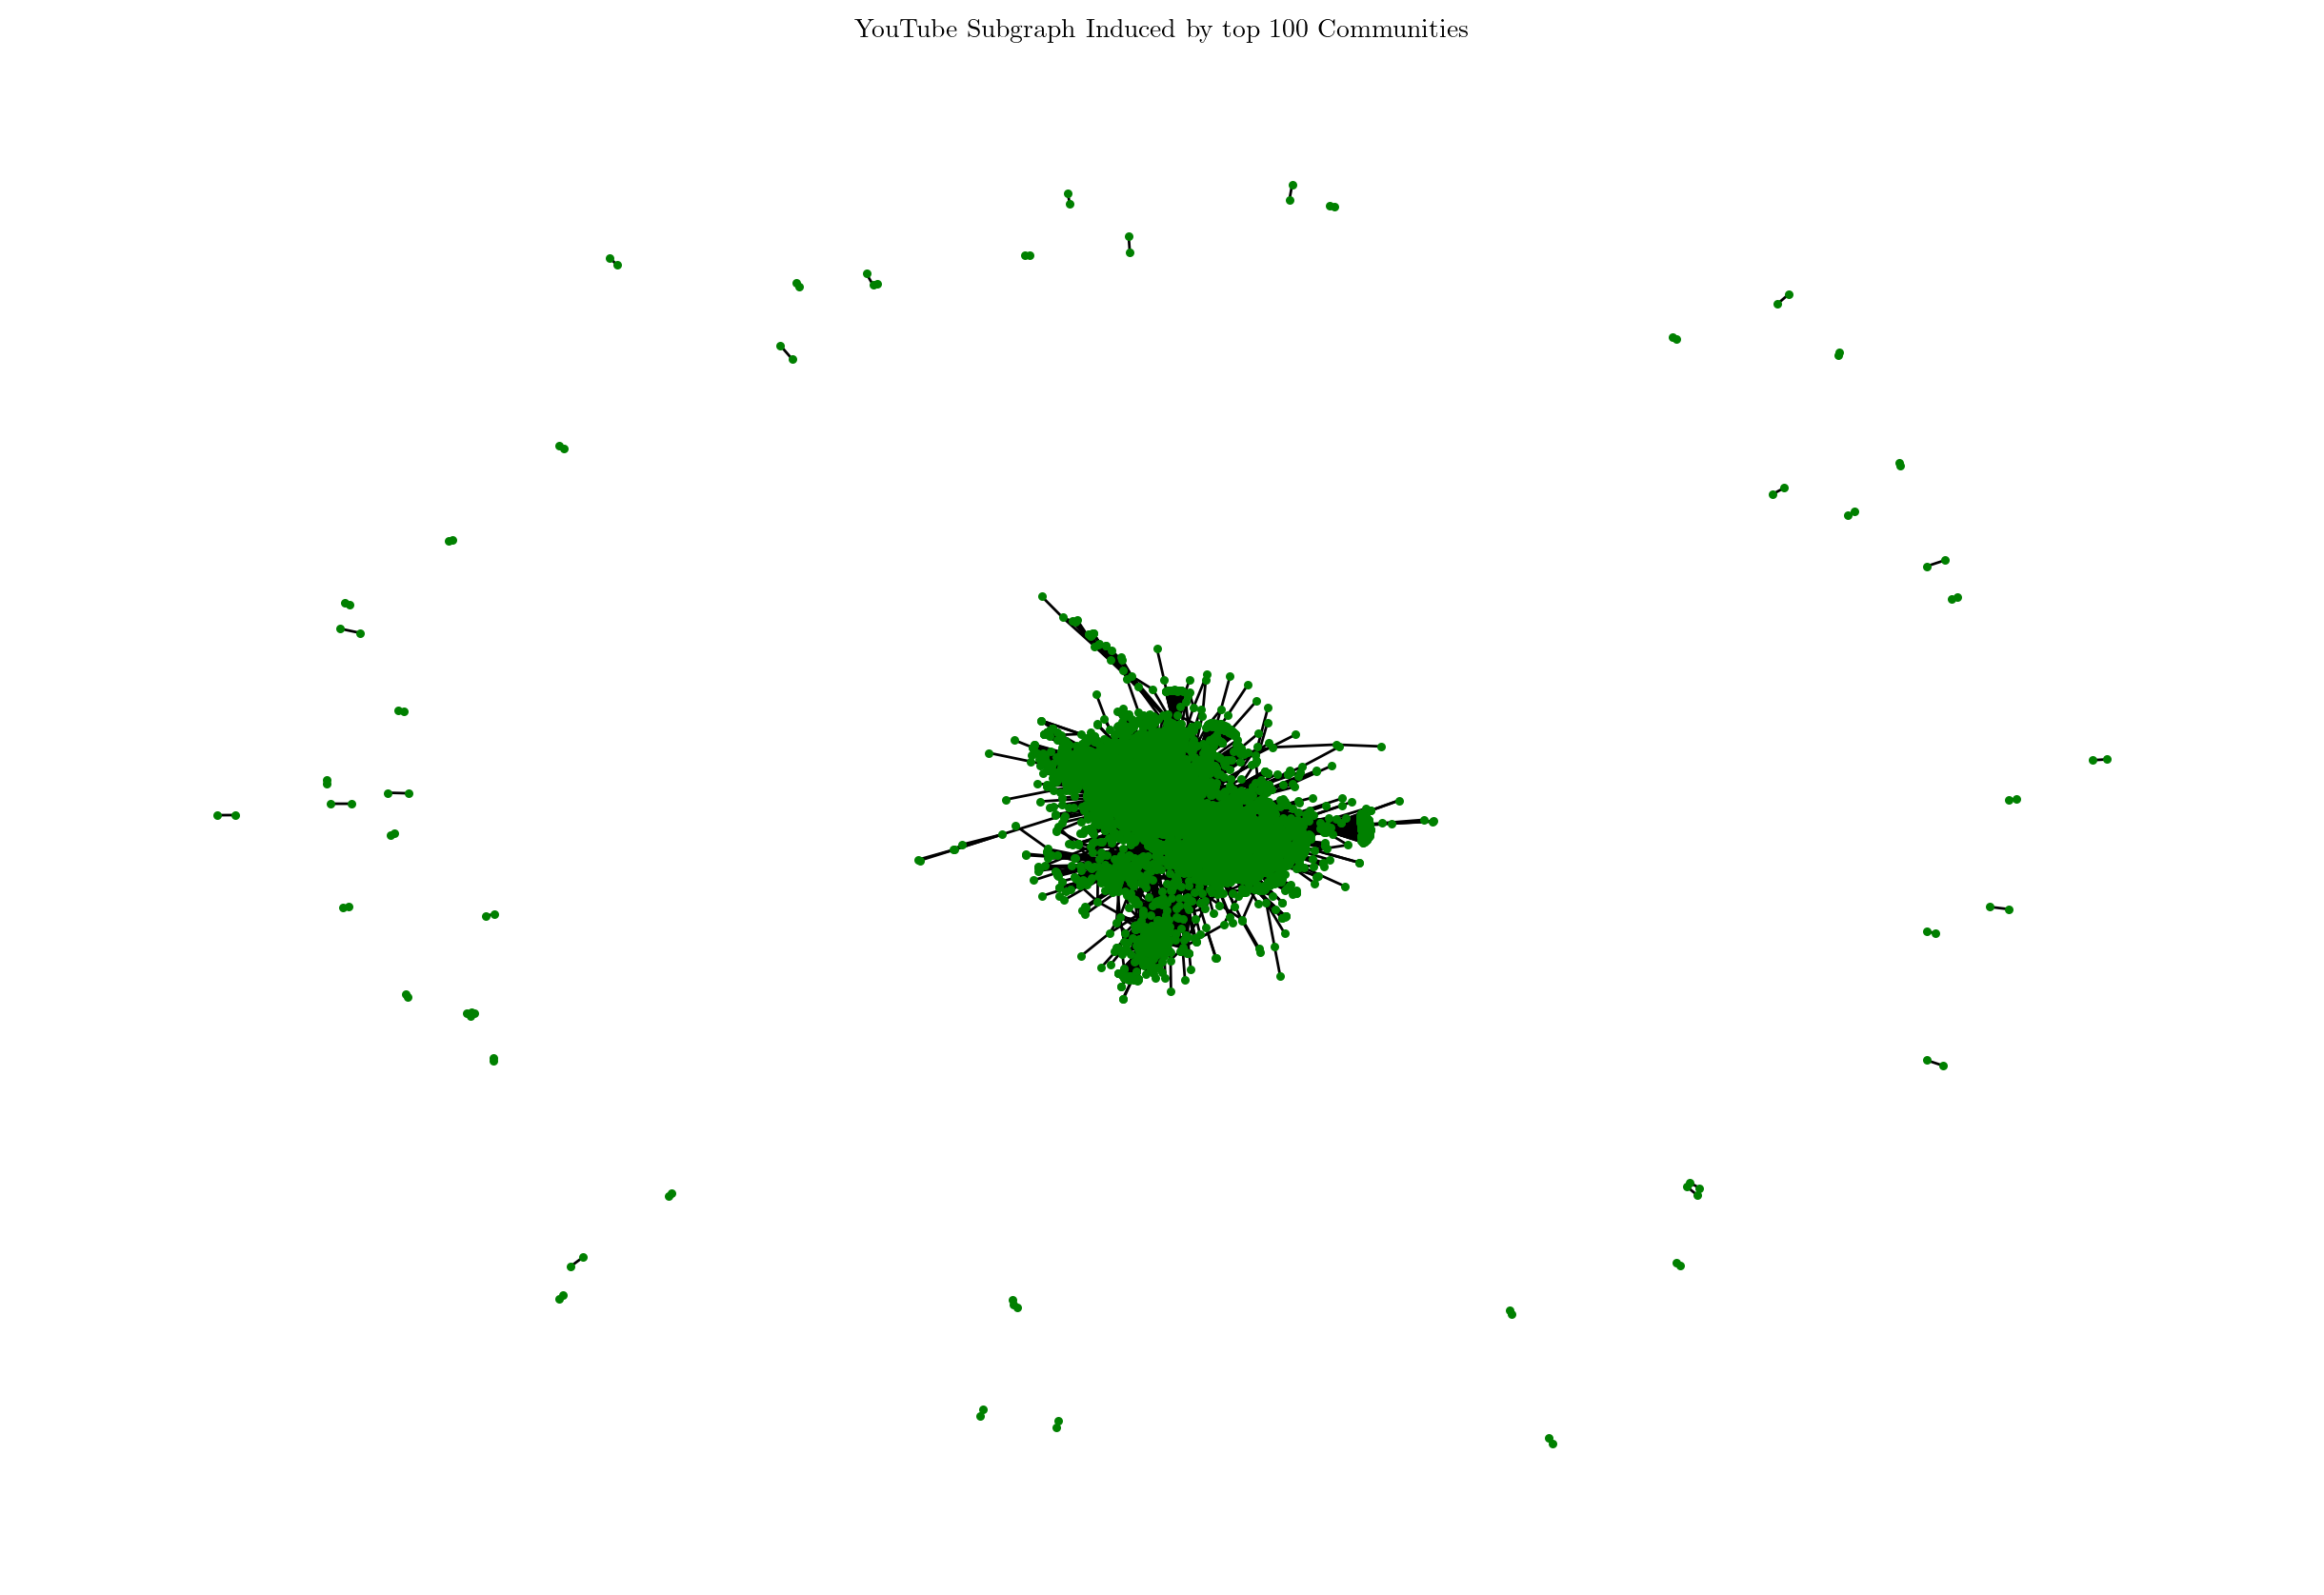

In [7]:
plt.figure(figsize = (12, 8))
nx.draw(G_ind_YT, with_labels = False, node_size = 5, node_color = "green", edge_color = "black", pos = nx.spring_layout(G_ind_YT, scale = 4))
plt.title("YouTube Subgraph Induced by top 100 Communities")
plt.show()

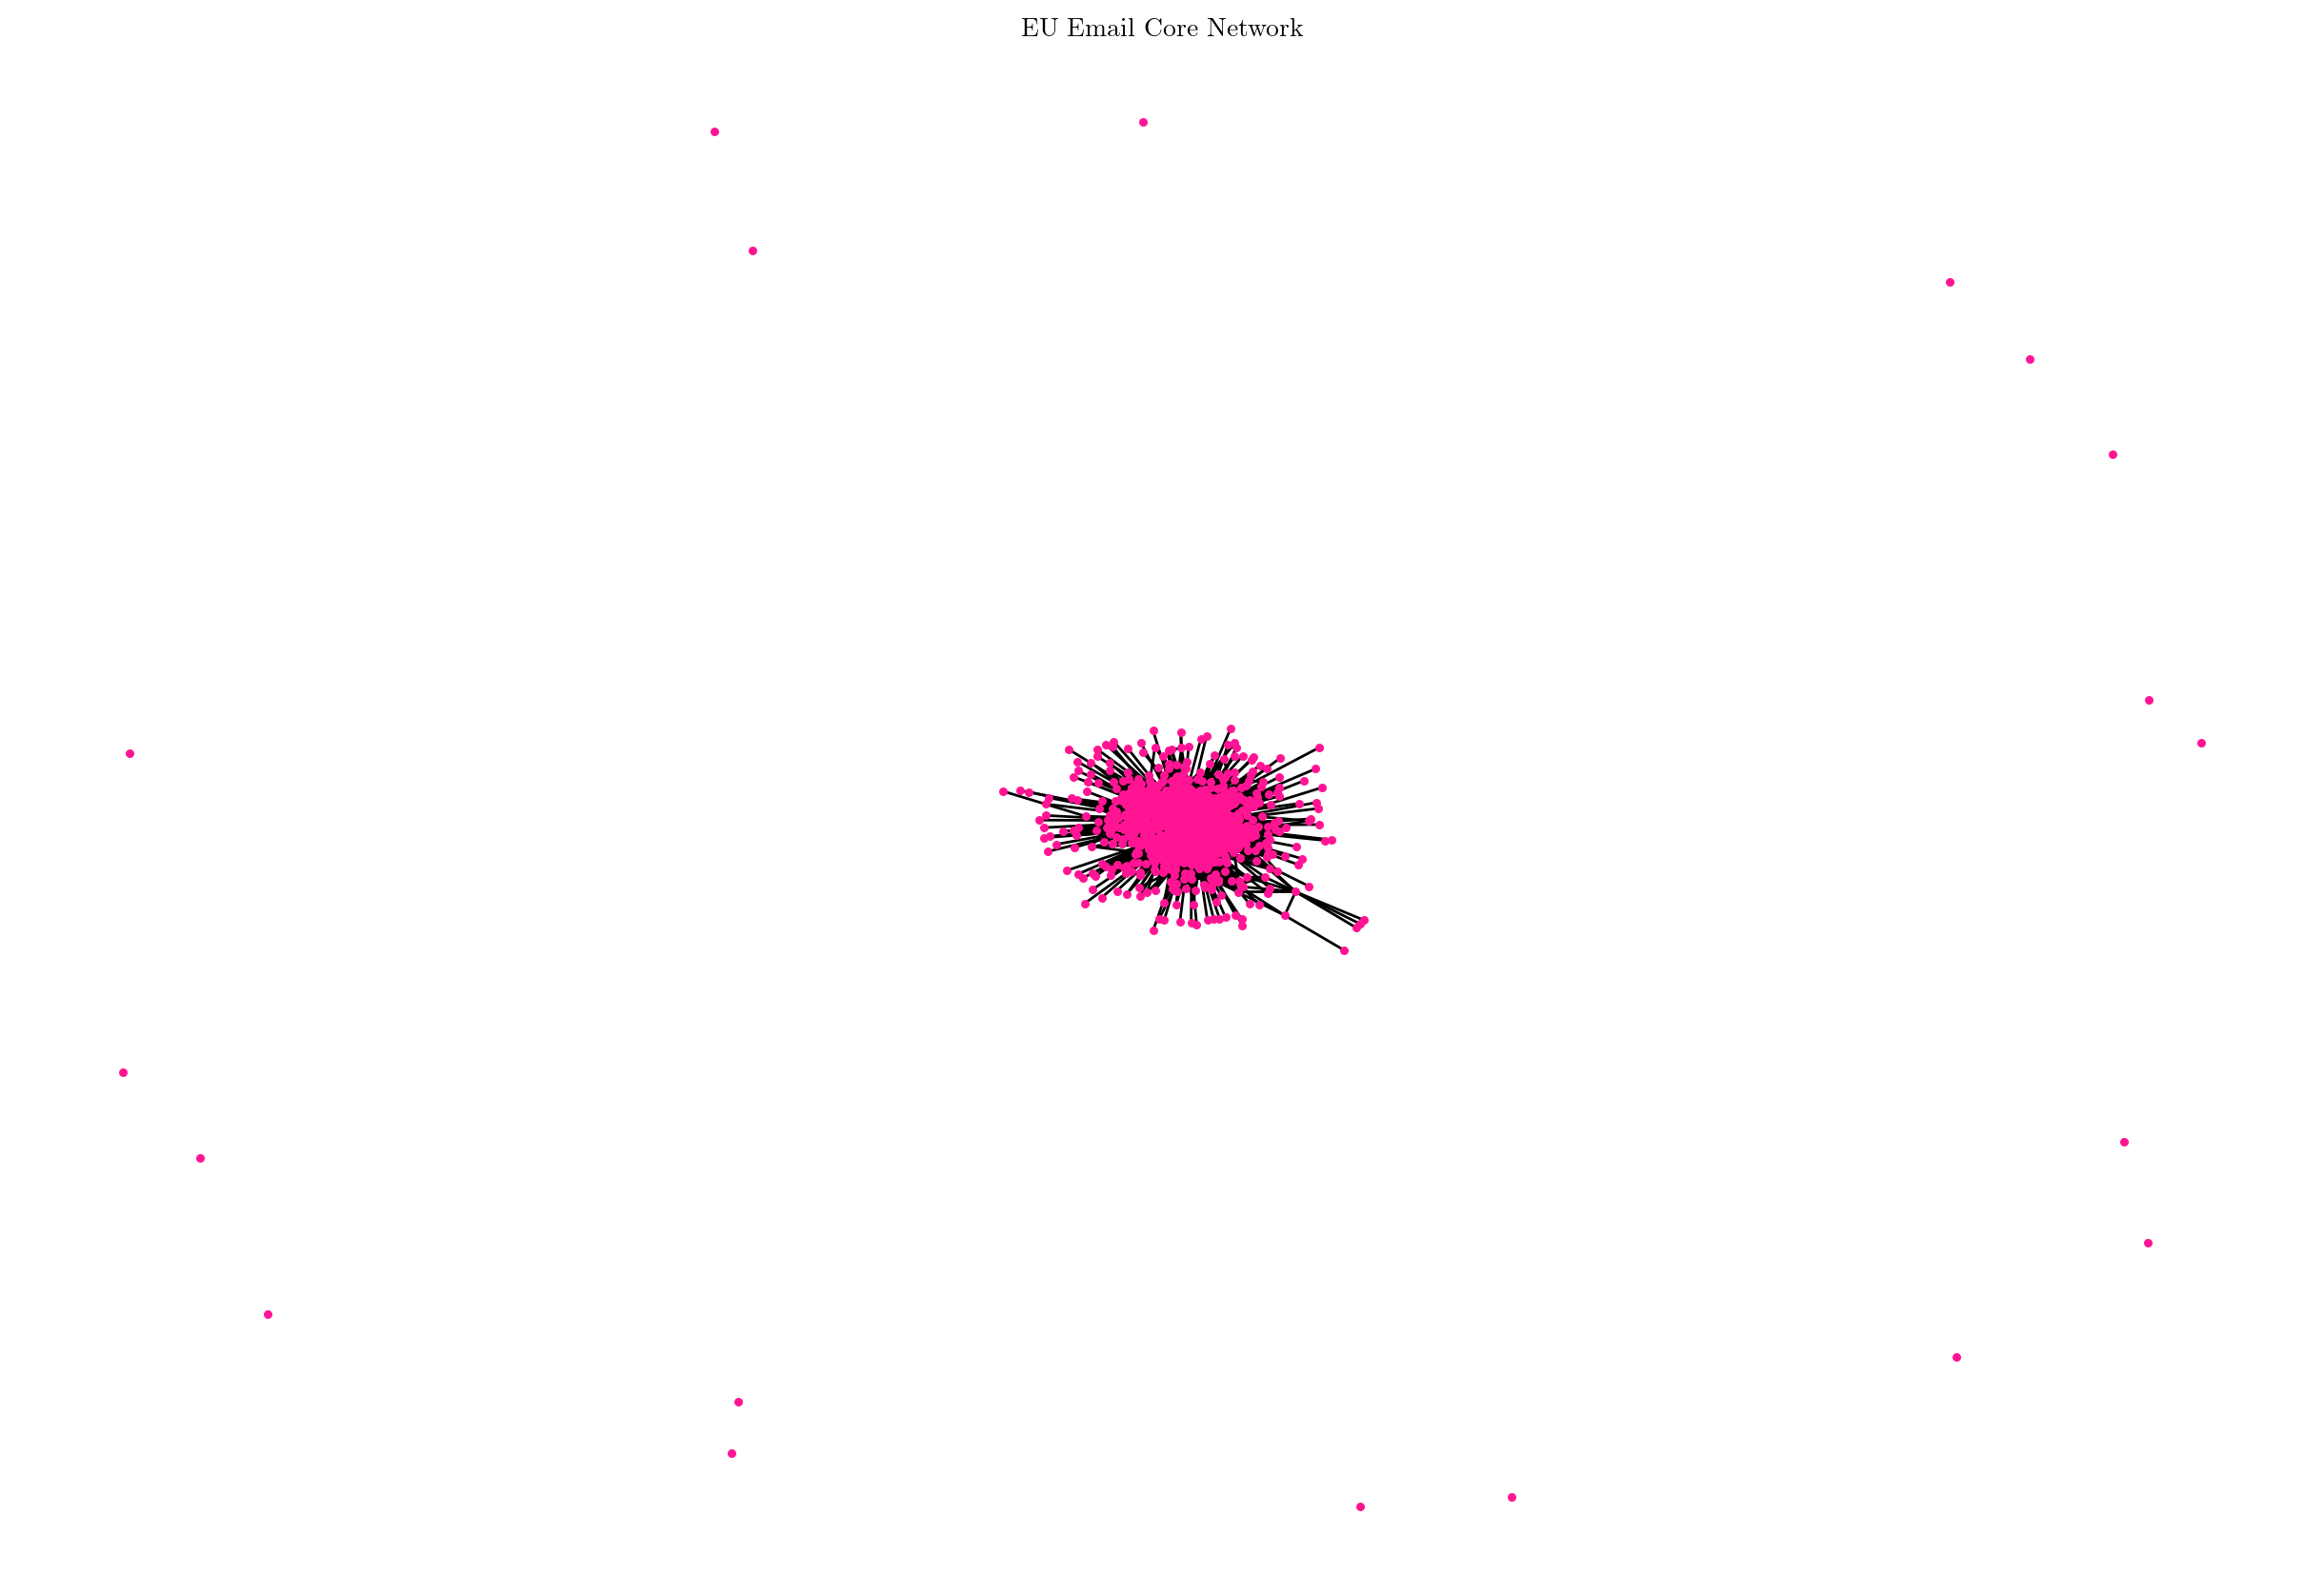

In [8]:
plt.figure(figsize = (12, 8))
nx.draw(G_eu, with_labels = False, node_size = 5, node_color = "deeppink", edge_color = "black", pos = nx.spring_layout(G_eu, scale = 4))
plt.title("EU Email Core Network")
plt.show()

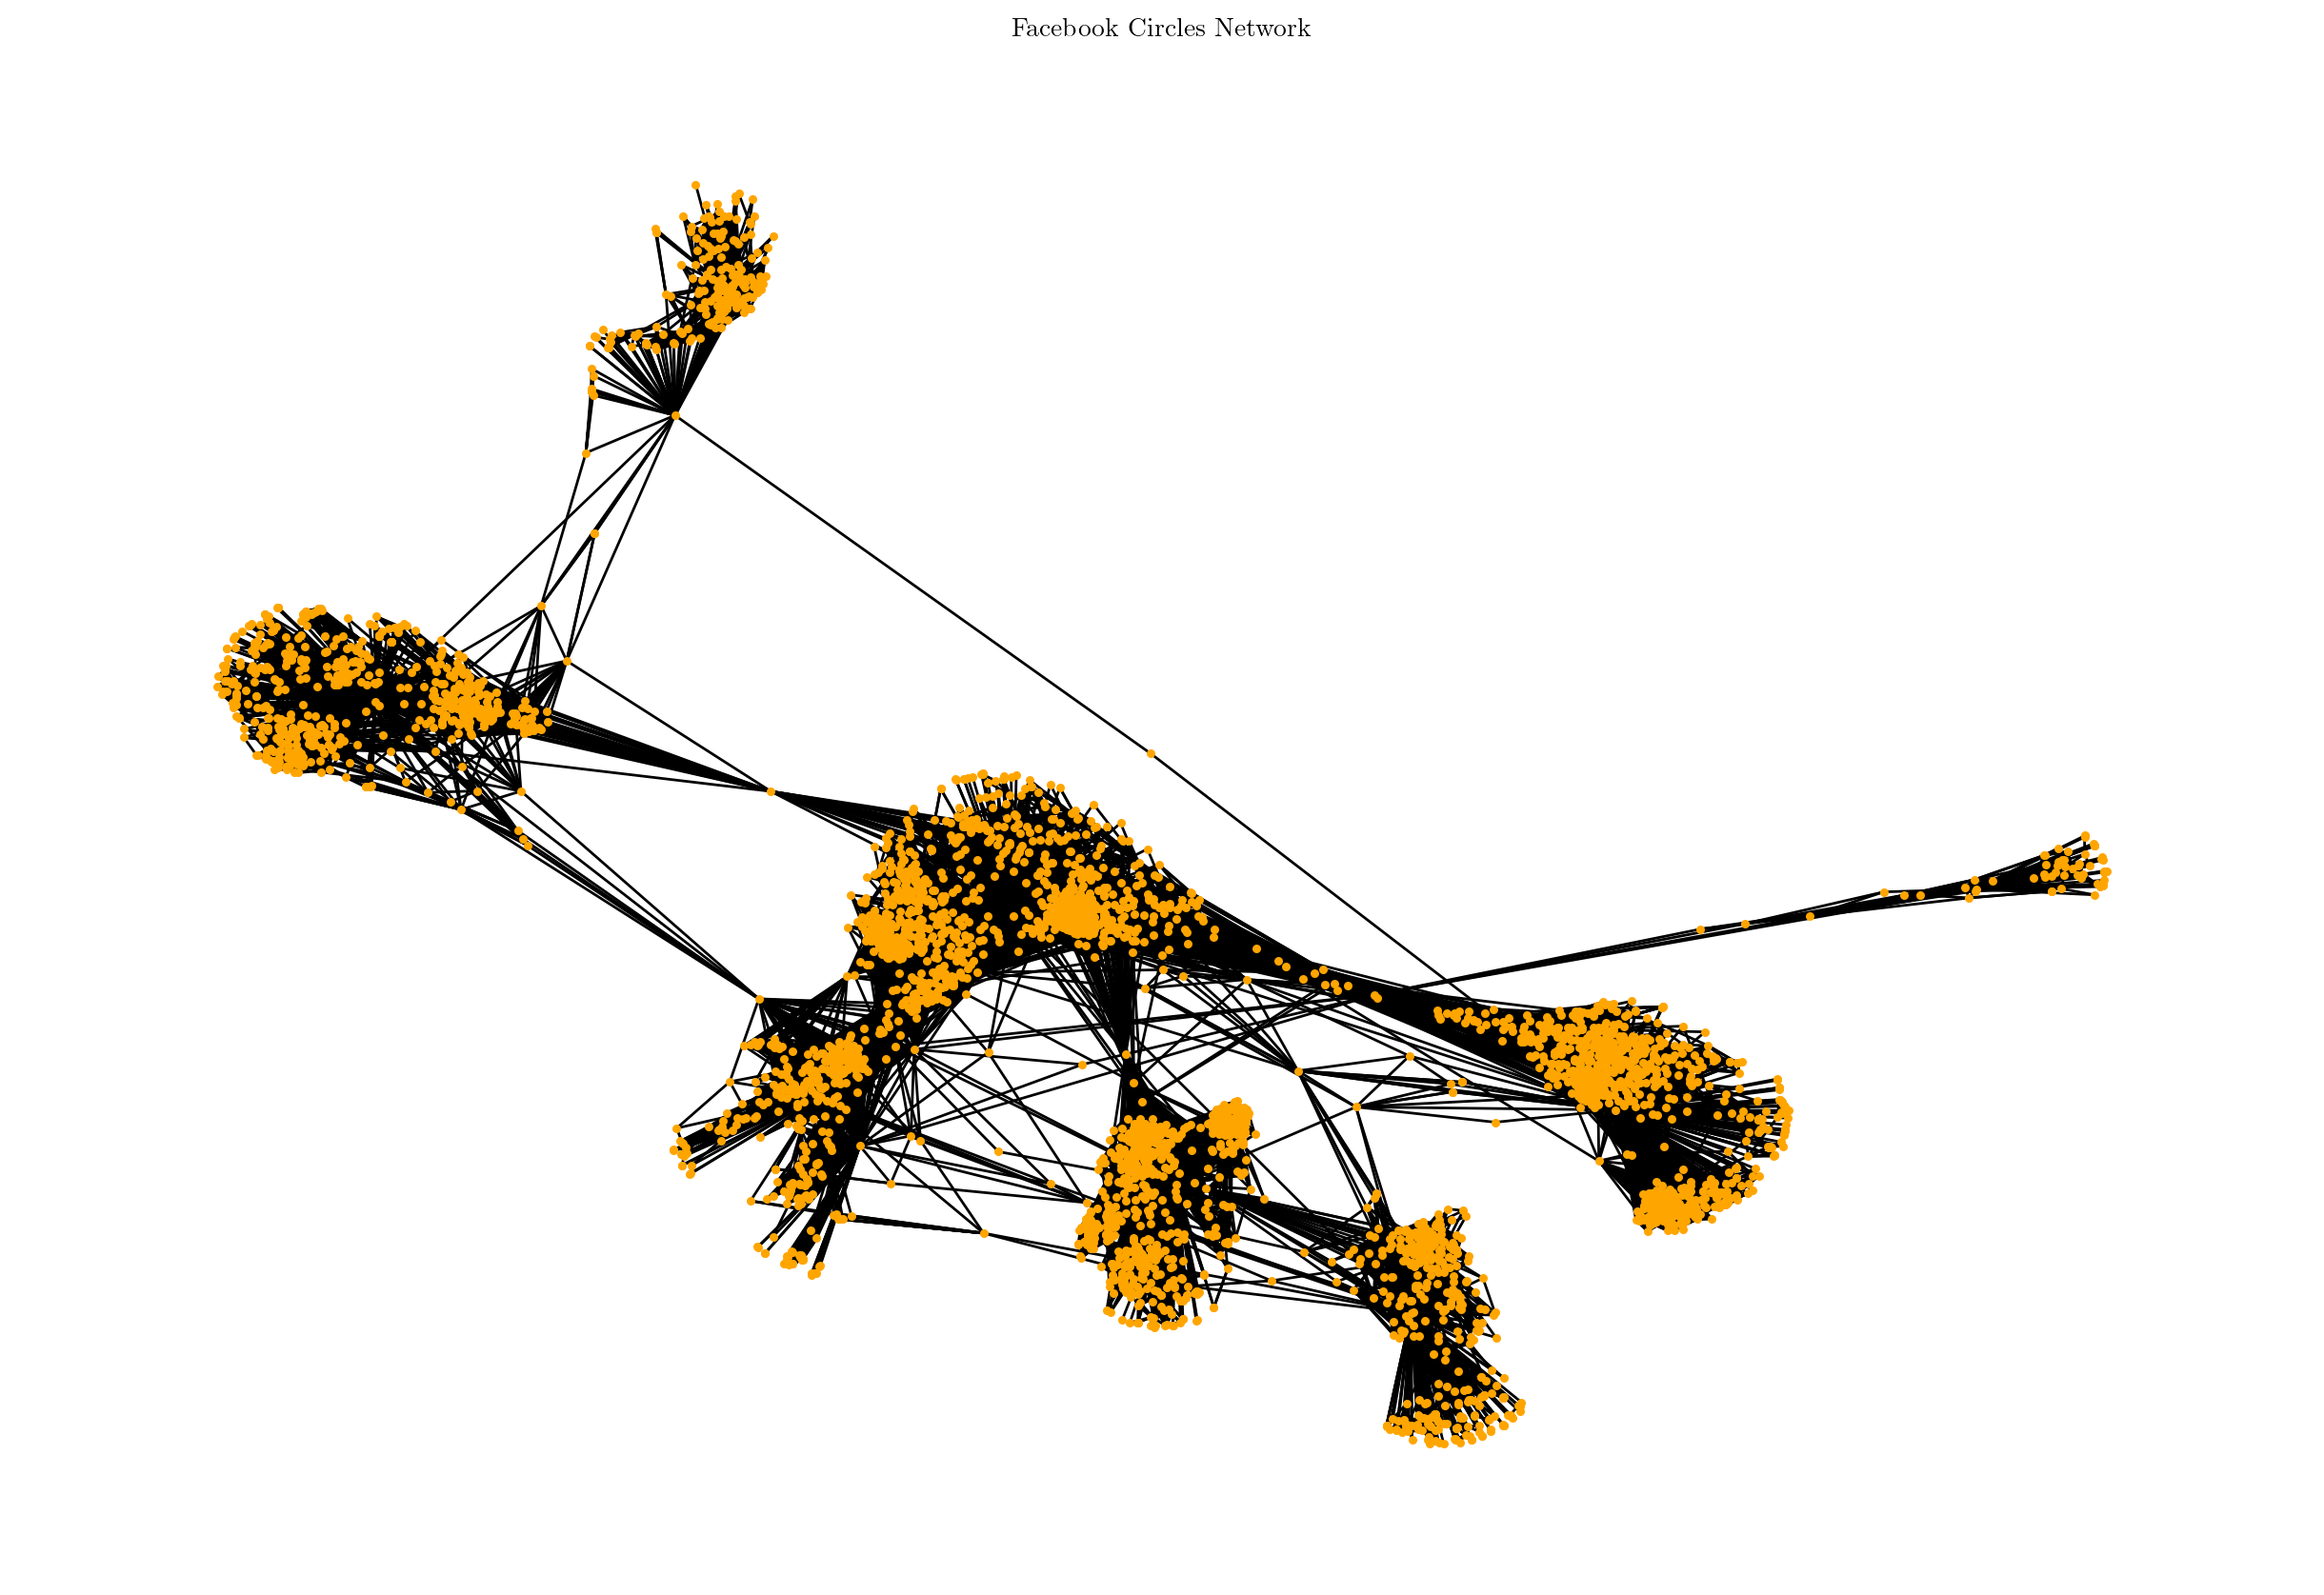

In [9]:
plt.figure(figsize = (12, 8))
nx.draw(G_FB, with_labels = False, node_size = 5, node_color = "orange", edge_color = "black", pos = nx.spring_layout(G_FB, scale = 4))
plt.title("Facebook Circles Network")
plt.show()

In [11]:
def edge_betweenness_sparsification(G, k):
    edge_betweenness = nx.edge_betweenness_centrality(G)
    edges_to_remove = sorted(edge_betweenness, key = edge_betweenness.get)[:int((1 - k) * G.number_of_edges())]
    H = G.copy()
    for edge in edges_to_remove:
        H.remove_edge(*edge)
    return H

In [12]:
def edge_random_sparsification(G, k):
    edges = list(G.edges())
    np.random.shuffle(edges)
    H = G.copy()
    for i in range(int((1 - k) * G.number_of_edges())):
        H.remove_edge(*edges[i])
    return H

In [13]:
def degree_based_edge_sampling(graph, sampling_ratio):
    sampled_graph = nx.Graph()
    total_edges = graph.number_of_edges()

    # Create a list of edges sorted by the product of their endpoint degrees
    edge_degrees = [(edge, 1/(graph.degree(edge[0]) * graph.degree(edge[1]))) for edge in graph.edges()]
    edge_degrees.sort(key=lambda x: x[1], reverse=True)
    edges = np.zeros((total_edges, 2))
    for i, e in enumerate(edge_degrees):
        edges[i] = e[0]
    
    # Determine the number of edges to retain based on the sampling ratio
    num_edges_to_retain = int(total_edges * sampling_ratio)

    # Sample the edges based on their degrees
    sorted_edge_prob = np.zeros(total_edges)
    for idx, edge_info in enumerate(edge_degrees):
        sorted_edge_prob[idx] = edge_info[1]
    sorted_edge_prob = sorted_edge_prob/np.sum(sorted_edge_prob)
    sampled_edges = np.random.choice(np.arange(total_edges), p = sorted_edge_prob, size = num_edges_to_retain, replace=False)

    # Add the sampled edges and original nodes to the sampled graph
    sampled_edges = edges[sampled_edges]
    sampled_graph.add_edges_from(sampled_edges)
    sampled_graph.add_nodes_from(graph.nodes)

    return sampled_graph

In [14]:
def spanning_tree_sampling(graph, sampling_ratio):

    # Construct a minimum spanning tree of the original graph
    spanning_tree = nx.minimum_spanning_tree(graph)

    # Convert the spanning tree to a graph
    sampled_graph = nx.Graph(spanning_tree.edges())

    # Get the total number of edges in the original graph
    total_edges = graph.number_of_edges()

    # Calculate the number of edges to retain based on the sampling ratio
    num_edges_to_retain = int(total_edges * sampling_ratio)

    # If the spanning tree has fewer edges than the required number of retained edges,
    # randomly sample additional edges from the original graph to meet the quota
    if sampled_graph.number_of_edges() < num_edges_to_retain:
        remaining_edges = num_edges_to_retain - sampled_graph.number_of_edges()
        remaining_edges_to_sample = random.sample(list(graph.edges()), remaining_edges)
        sampled_graph.add_edges_from(remaining_edges_to_sample)

    return sampled_graph

In [15]:
k_values = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01]
sparseFunctions = [("Edge Betweenness", edge_betweenness_sparsification), ("Random", edge_random_sparsification), ("Degree-based Edge Sampling", degree_based_edge_sampling), ("Spanning Tree Sampling", spanning_tree_sampling)]

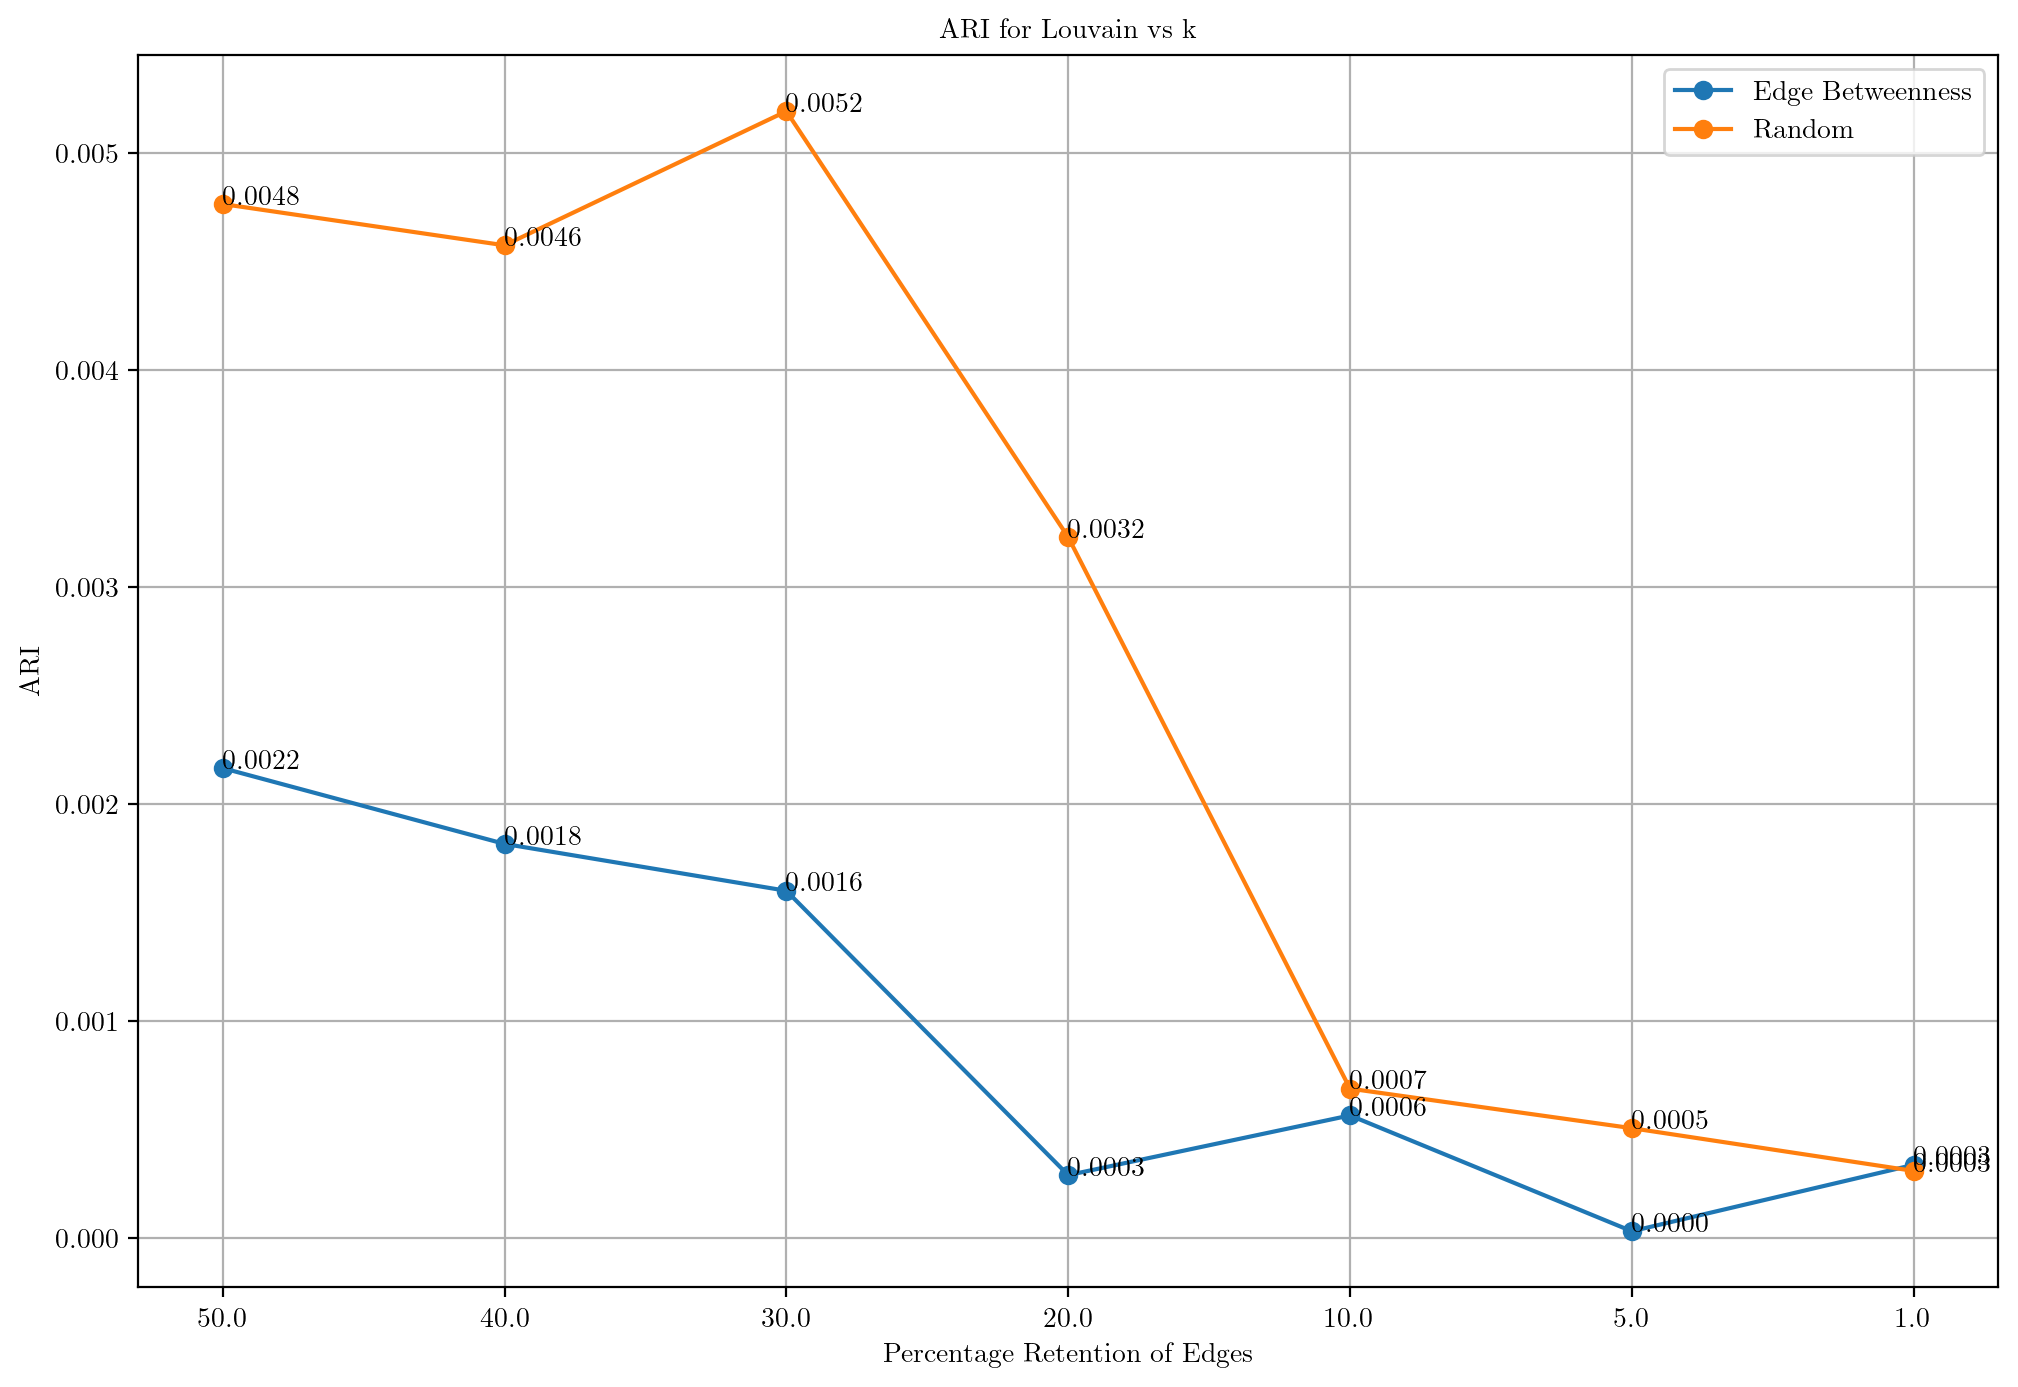

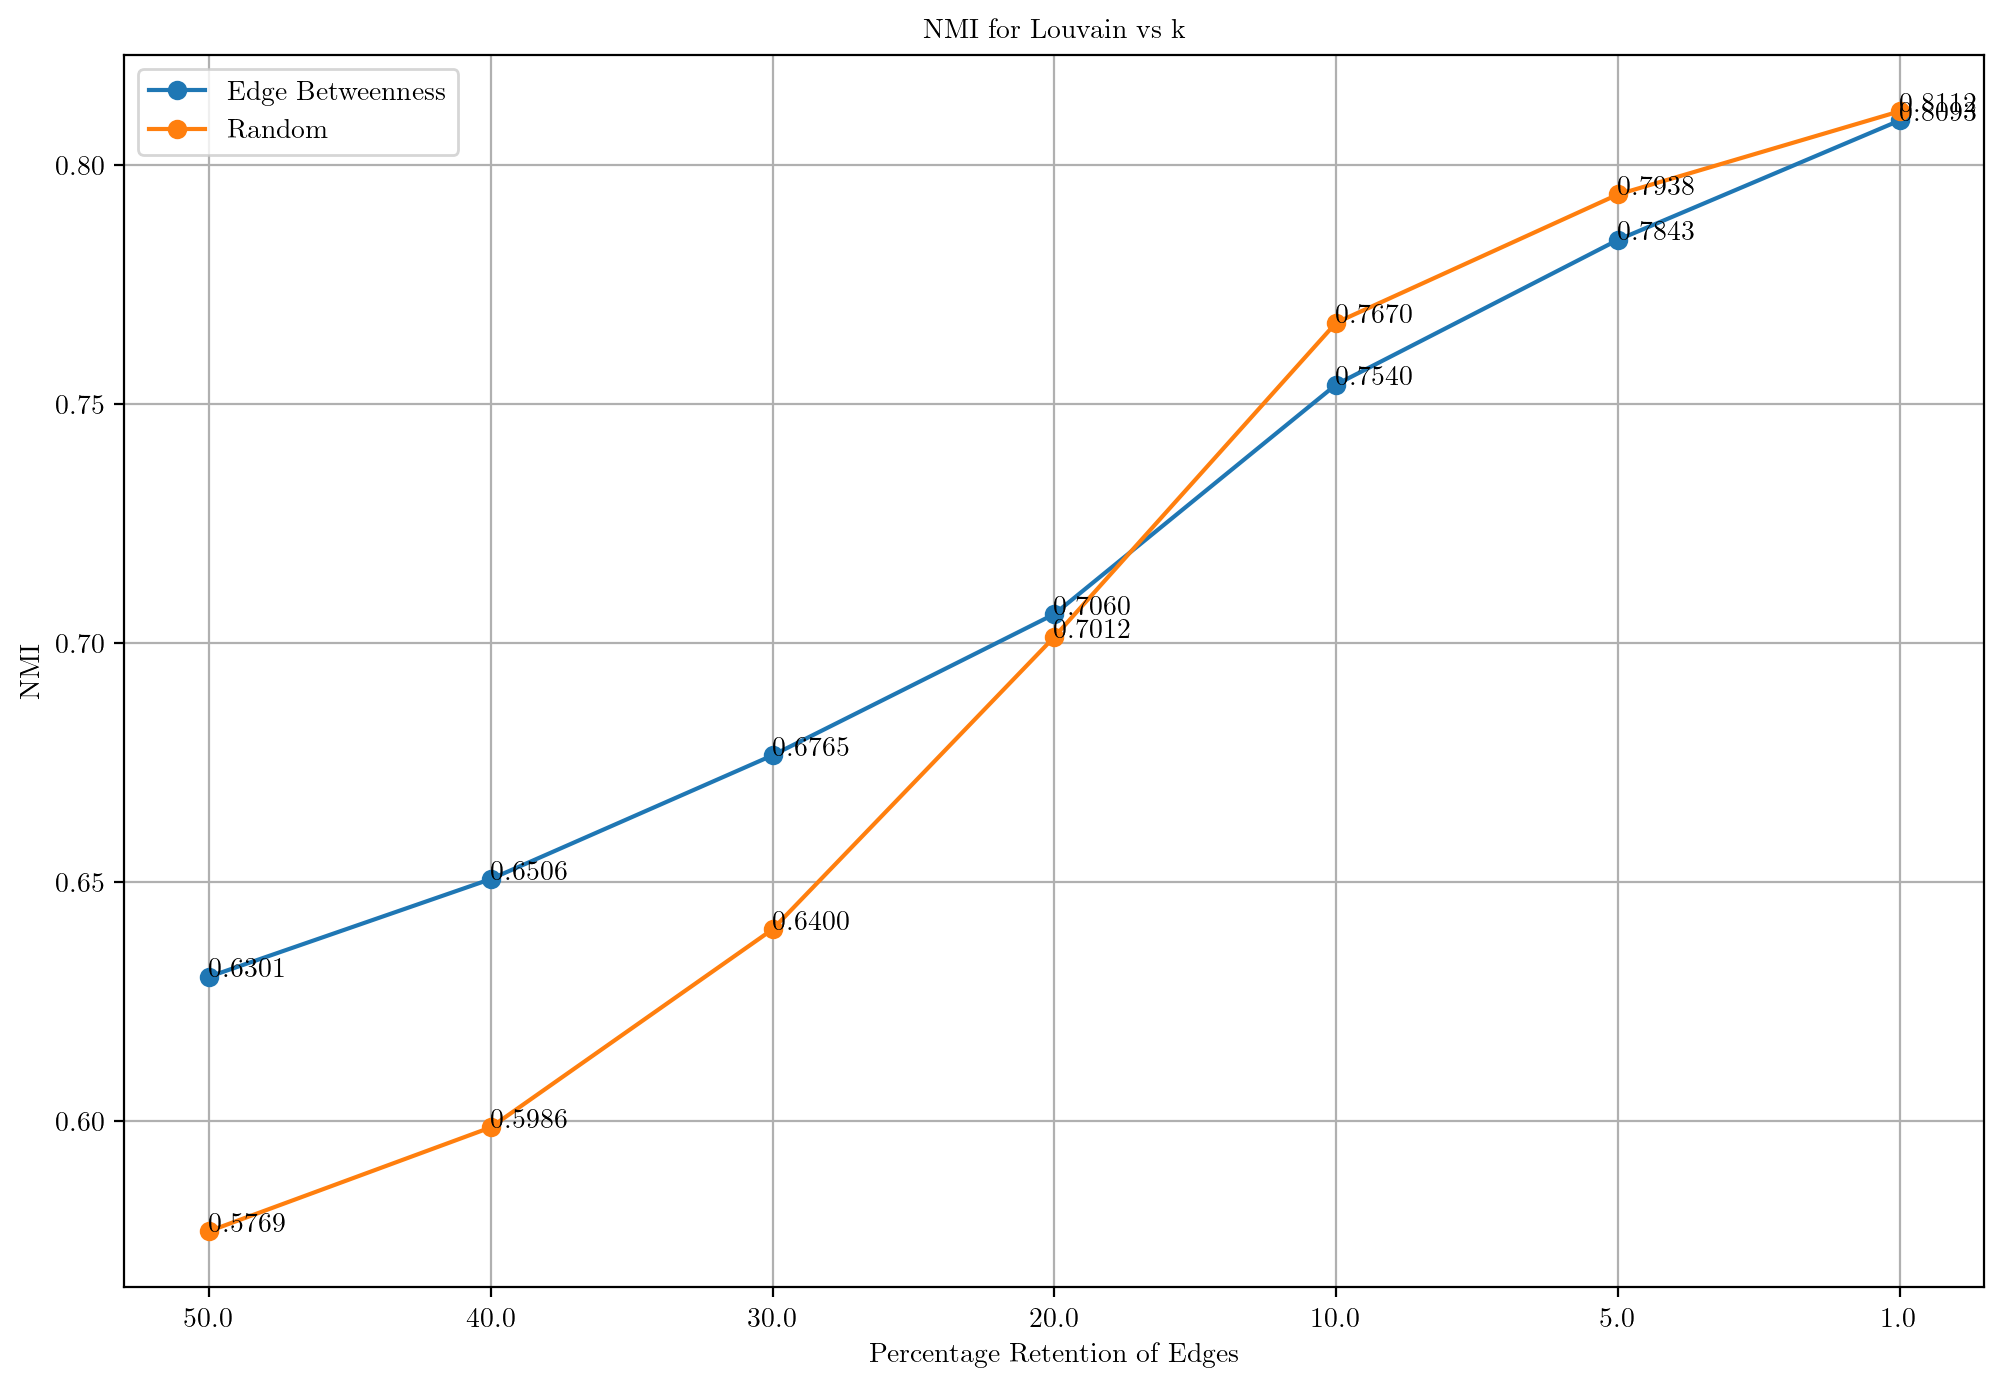

In [13]:
sparseAmzGraphs = plot_metrics_sparse(G_ind_Amz, get_community_dict(list(communitiesAmazon.values())), sparseFunctions, k_values)

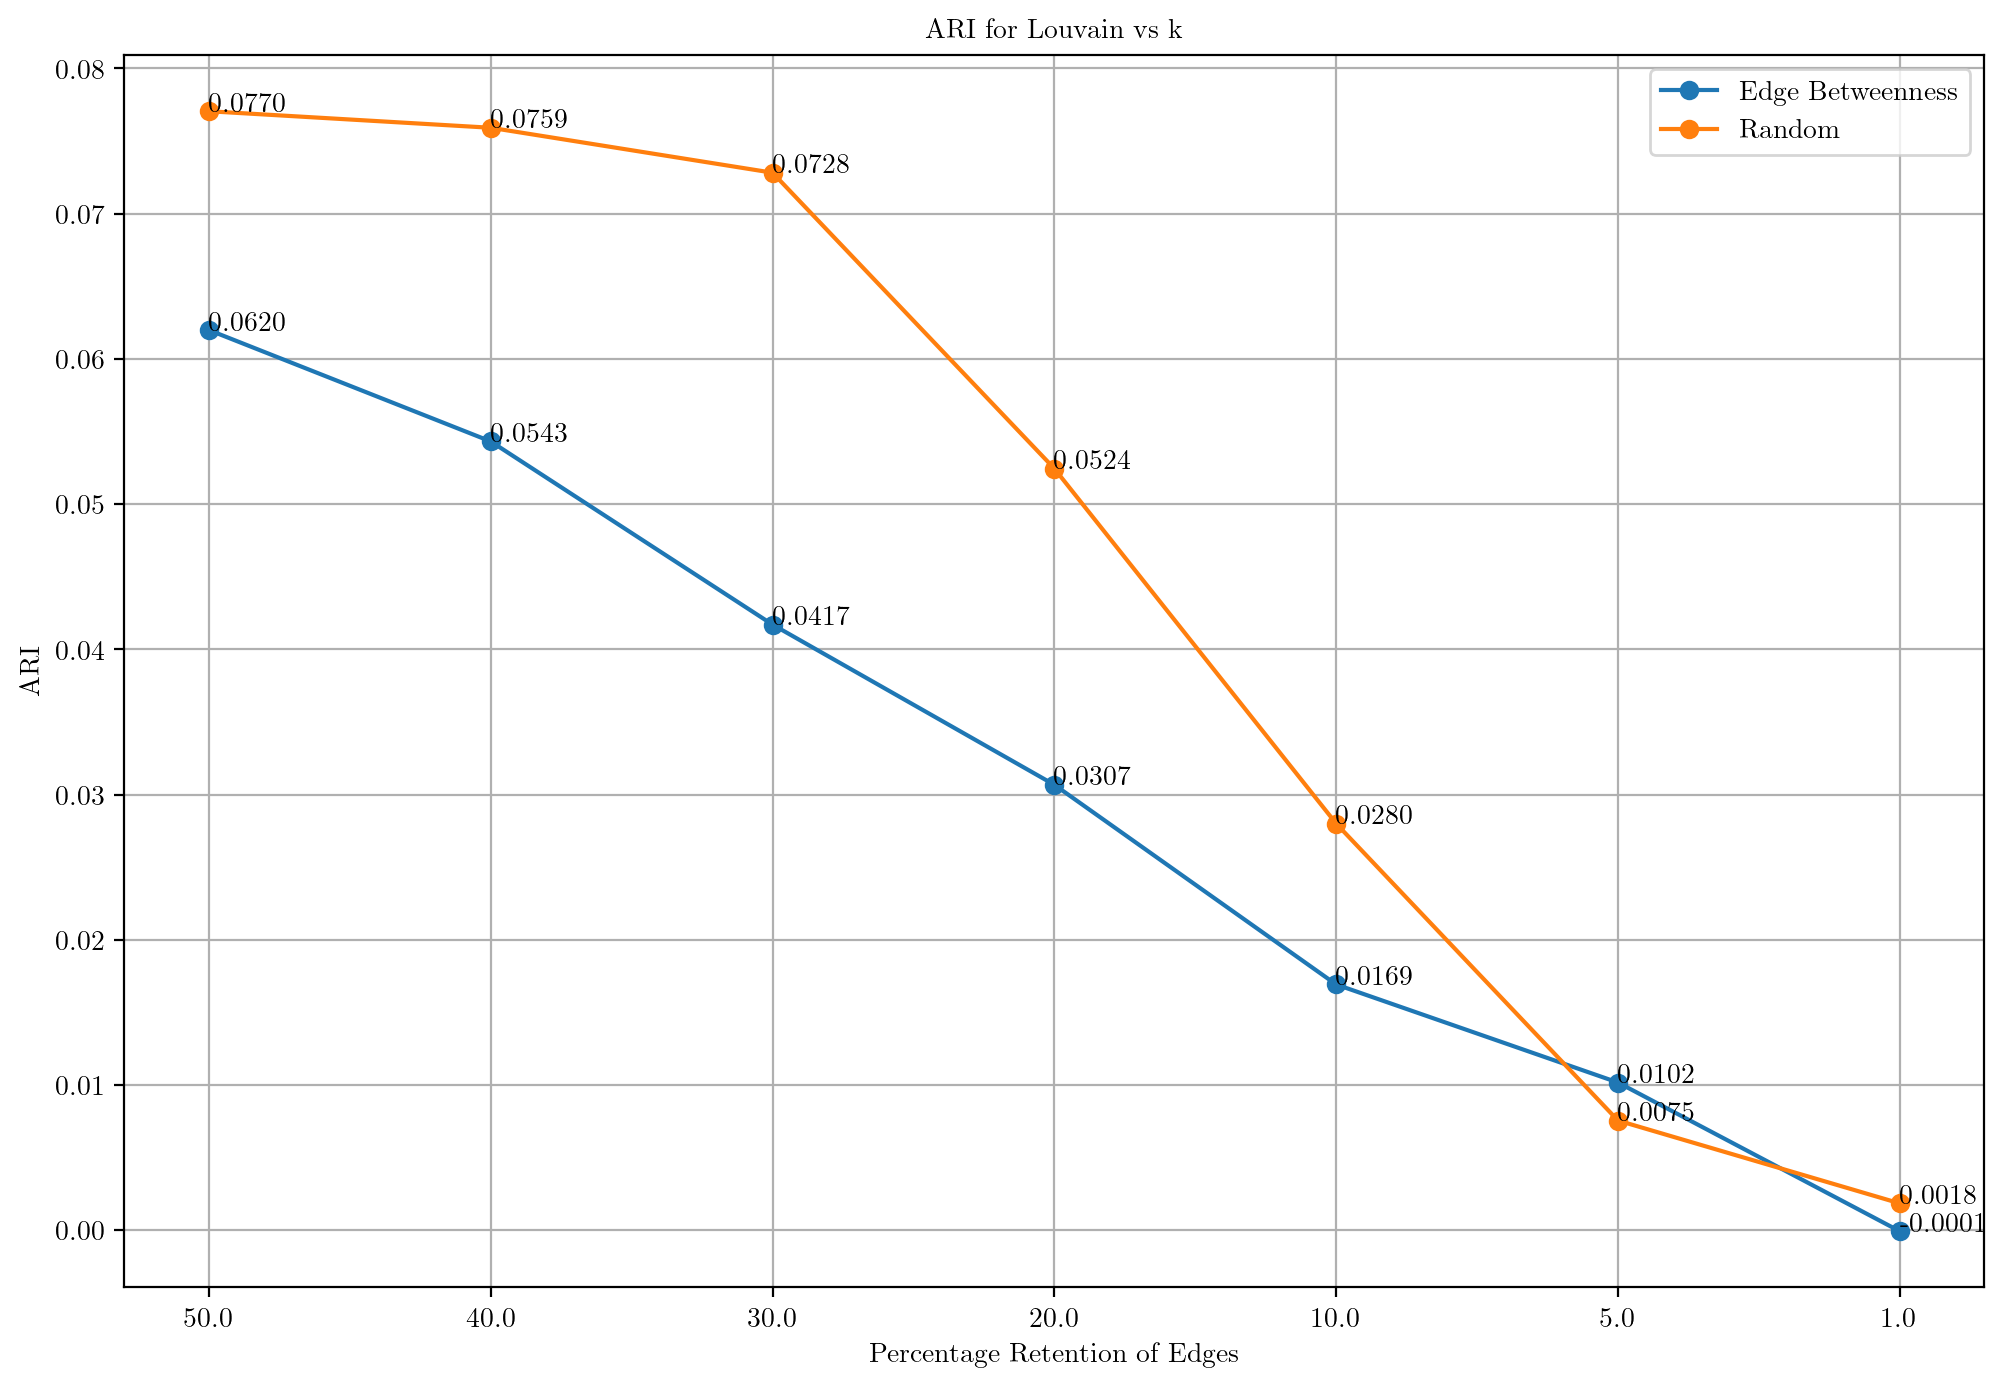

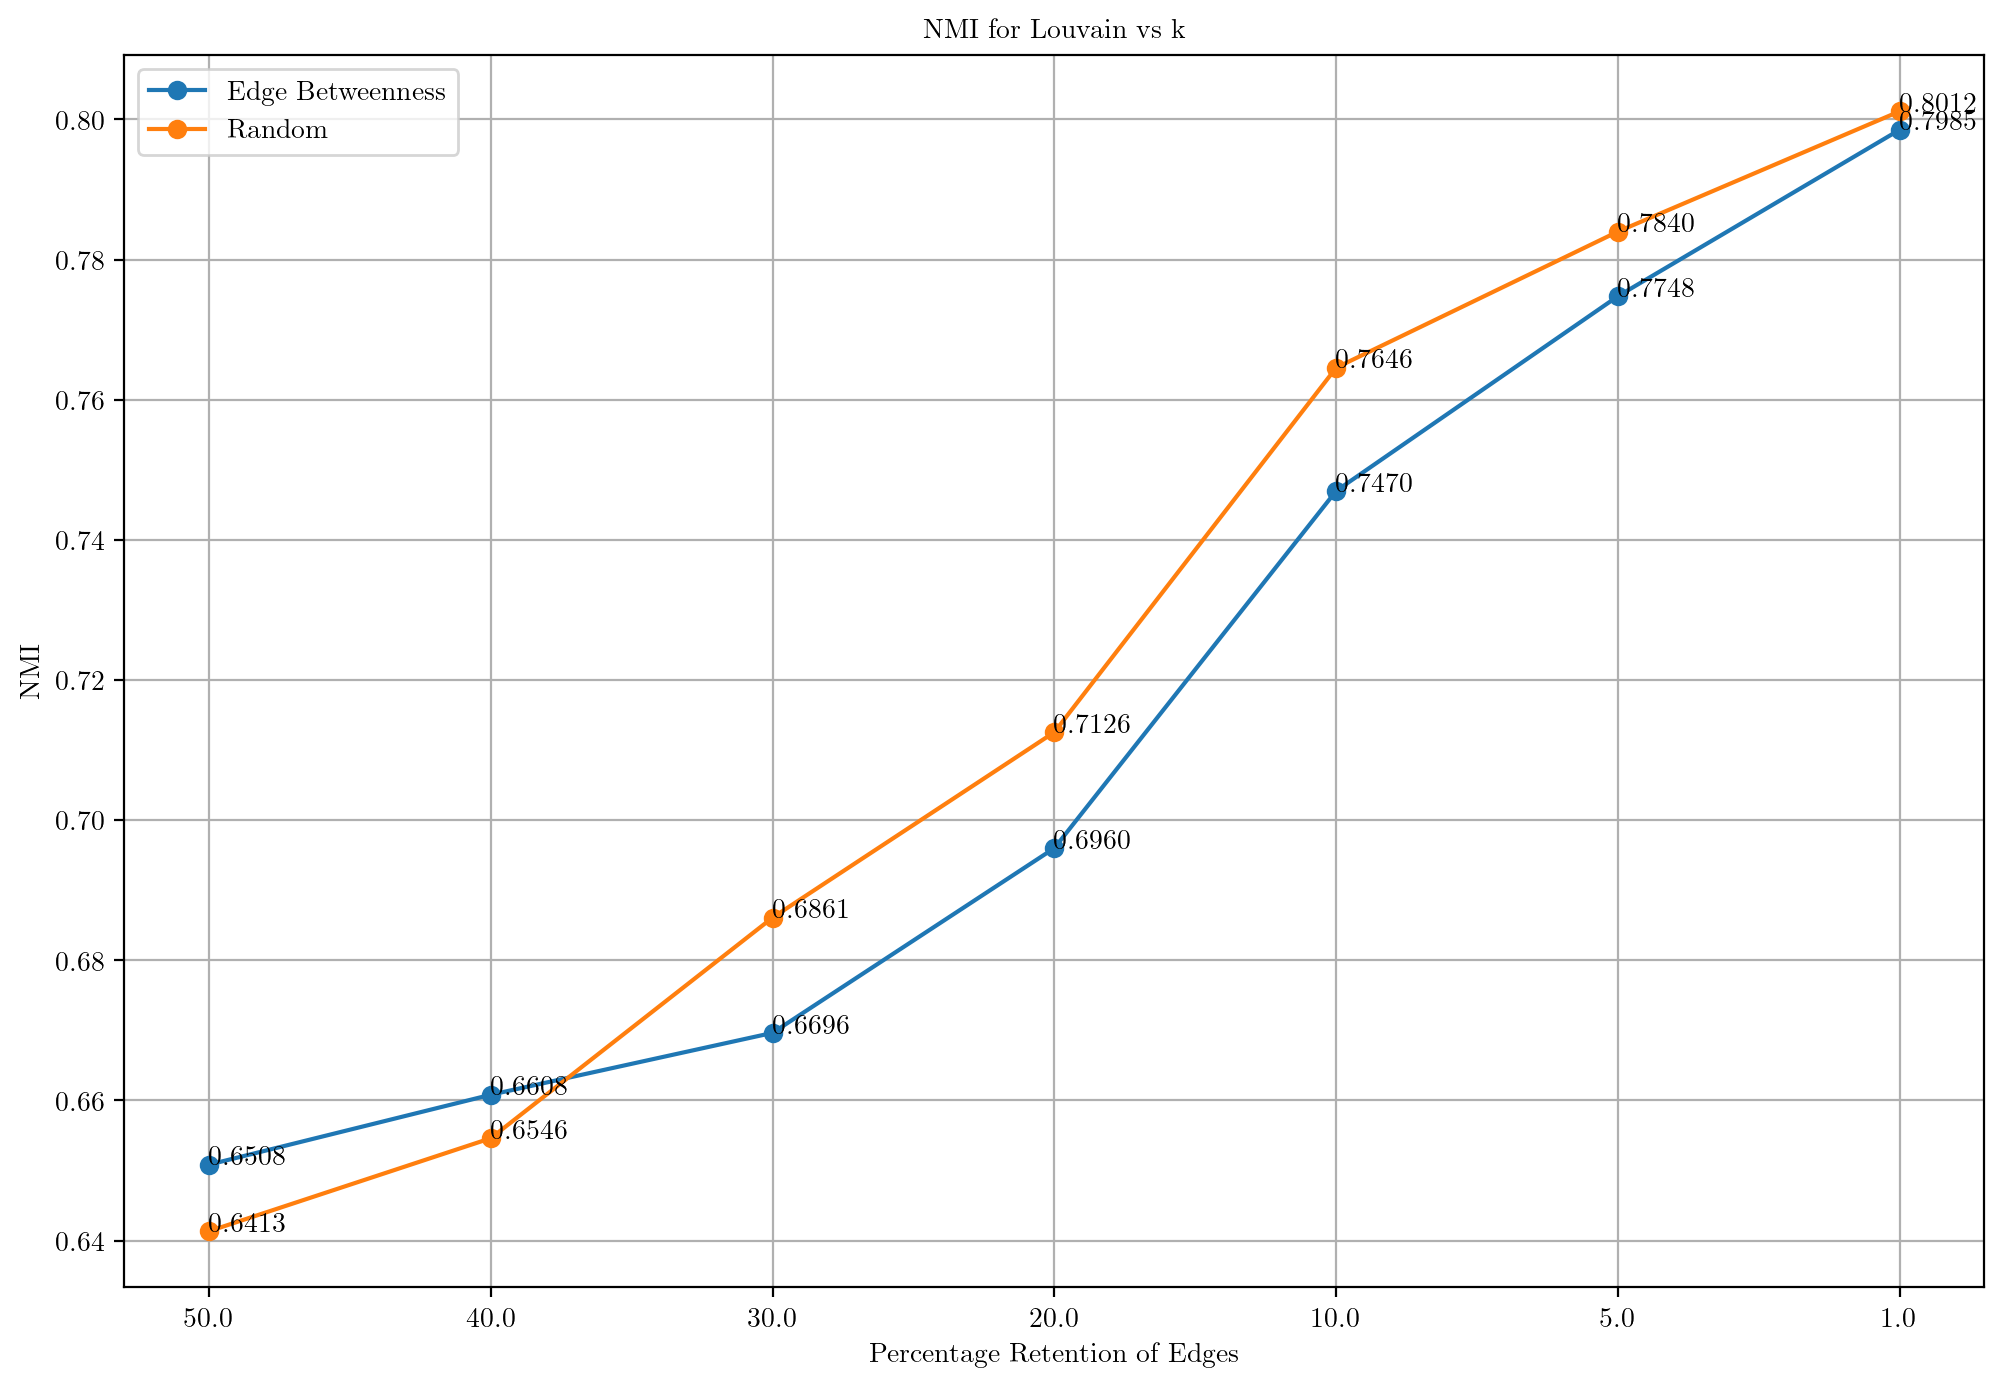

In [14]:
sparseDBLPGraphs = plot_metrics_sparse(G_ind_DBLP, get_community_dict(list(communitiesDBLP.values())), sparseFunctions, k_values)

In [18]:
from cdlib import algorithms

In [16]:
def edge_jaccard_sparsification(G, k):
    edge_jaccard = nx.jaccard_coefficient(G)
    edges = list(edge_jaccard)
    edges = sorted(edges, key = lambda x: x[2], reverse = True)
    G_sparse = set()
    H = nx.Graph()
    for edge in edges[:int(k * G.number_of_edges())]:
        G_sparse.add(edge[:2])
    
    for node in G.nodes():
        H.add_node(node)
    
    for edge in G_sparse:
        H.add_edge(edge[0], edge[1])
    return H


def edge_L_Spar_sparsification(G, r):
    G_sparse = set()
    H = nx.Graph()
    for node in G.nodes():
        edges = list(G.edges(node))
        edge_sim = nx.jaccard_coefficient(G, edges)
        edges = sorted(edge_sim, key = lambda x: x[2], reverse = True)
        for edge in edges[:int(len(edges)**r)]:
            G_sparse.add(edge[:2])
    for node in G.nodes():
        H.add_node(node)
    for edge in G_sparse:
        H.add_edge(edge[0], edge[1])
    return H

In [19]:
k_values = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01]
sparseFunctions = [("Edge Betweenness", edge_betweenness_sparsification), ("Random", edge_random_sparsification), ("Degree-based Edge Sampling", degree_based_edge_sampling), ("Spanning Tree Sampling", spanning_tree_sampling), ("Edge Jaccard JC", edge_jaccard_sparsification), (r"$^*$Edge Local Search L-Spar", edge_L_Spar_sparsification)]

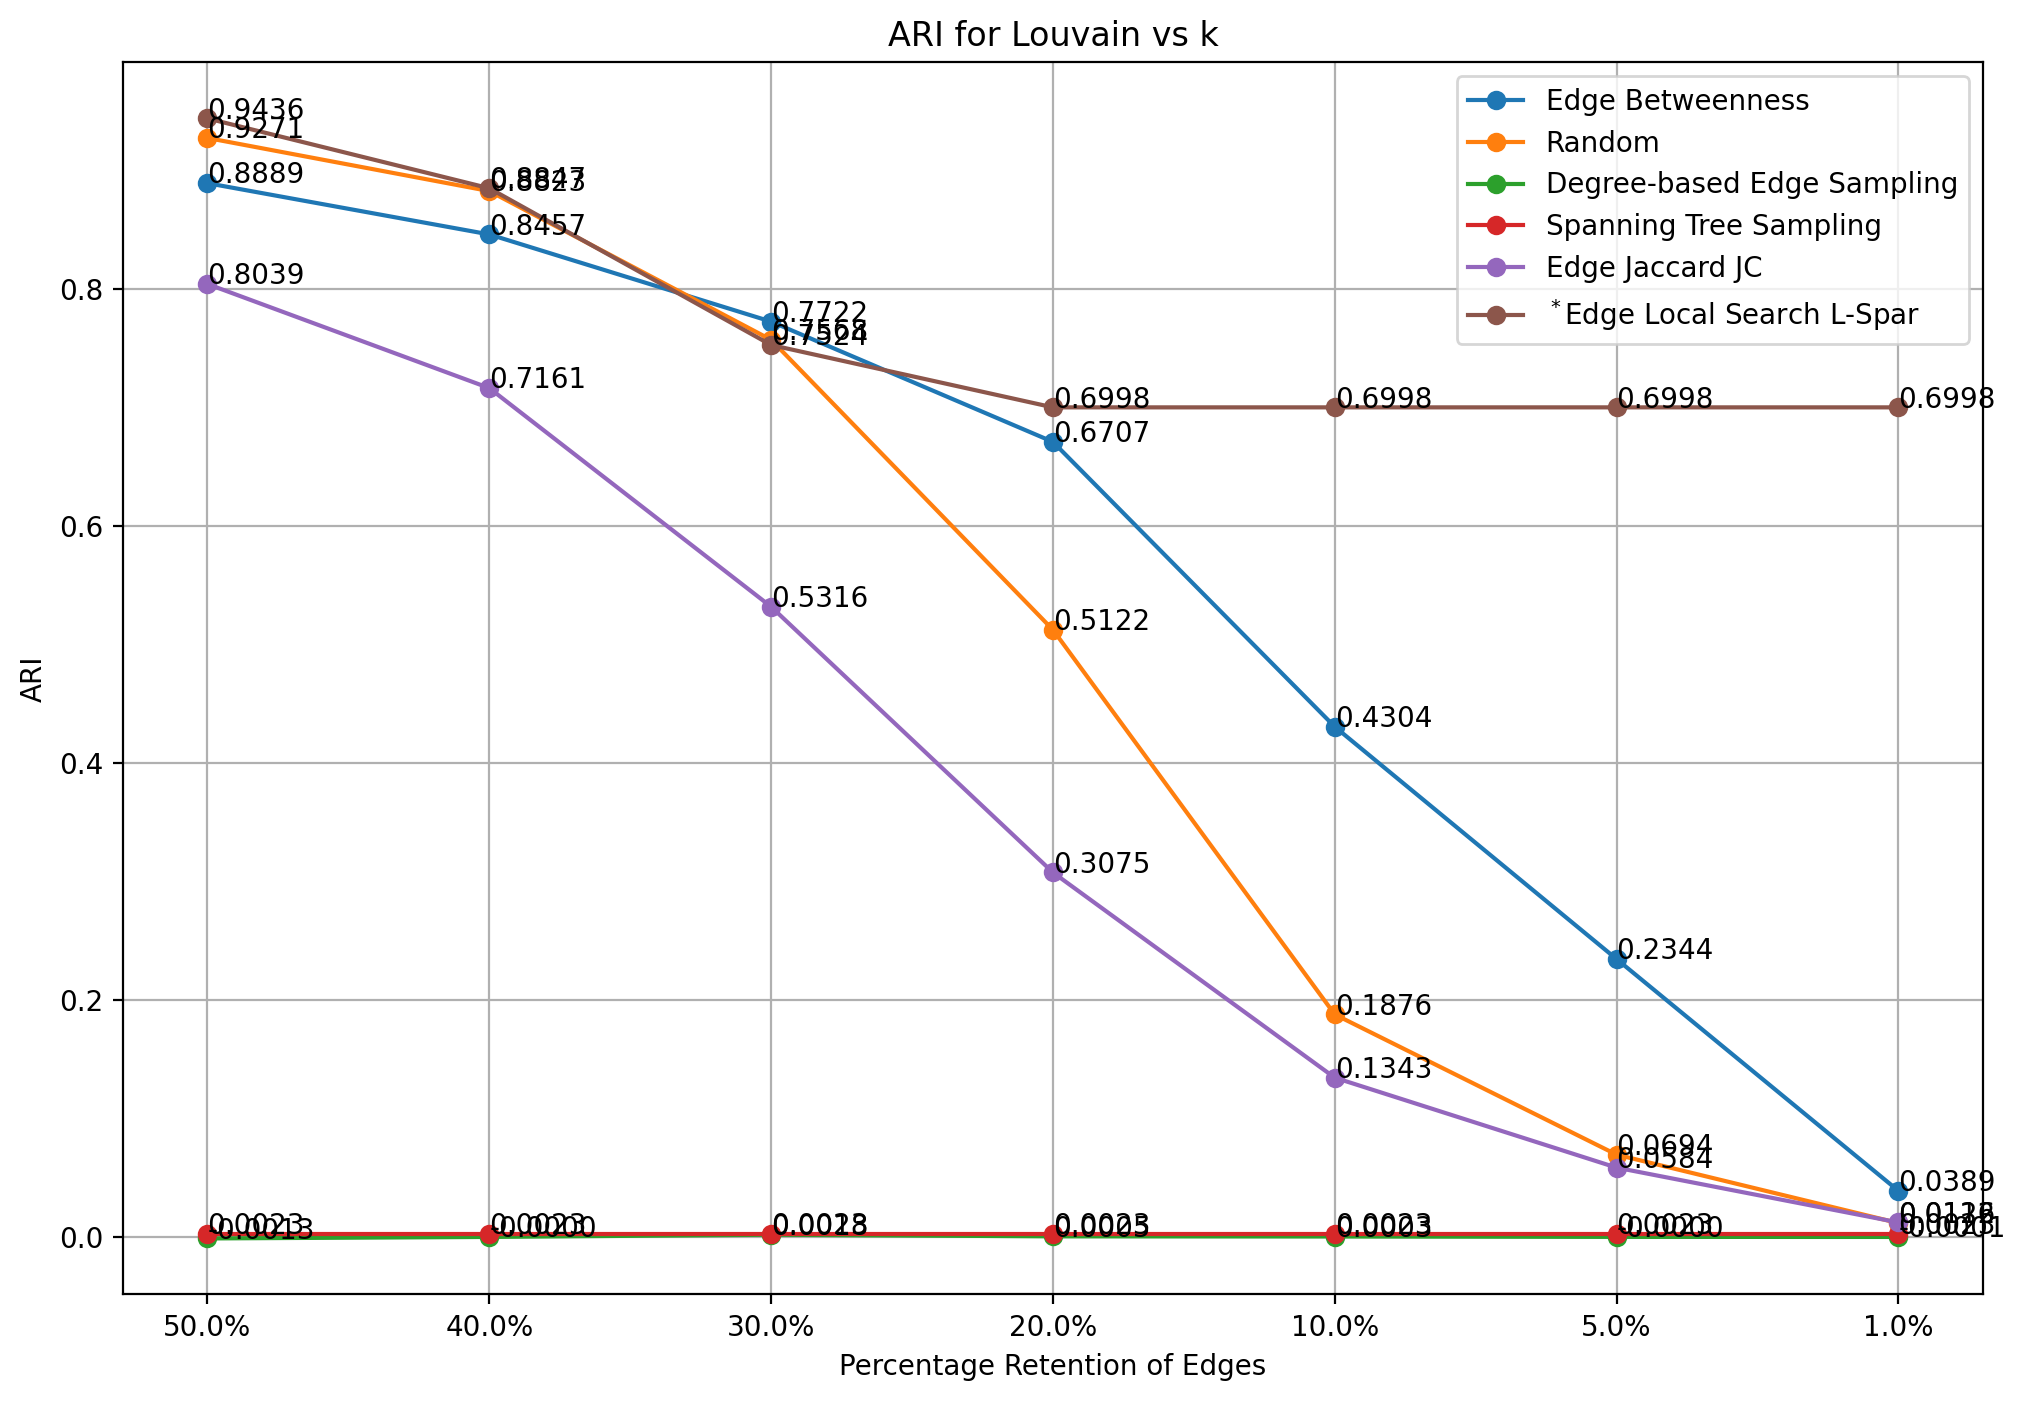

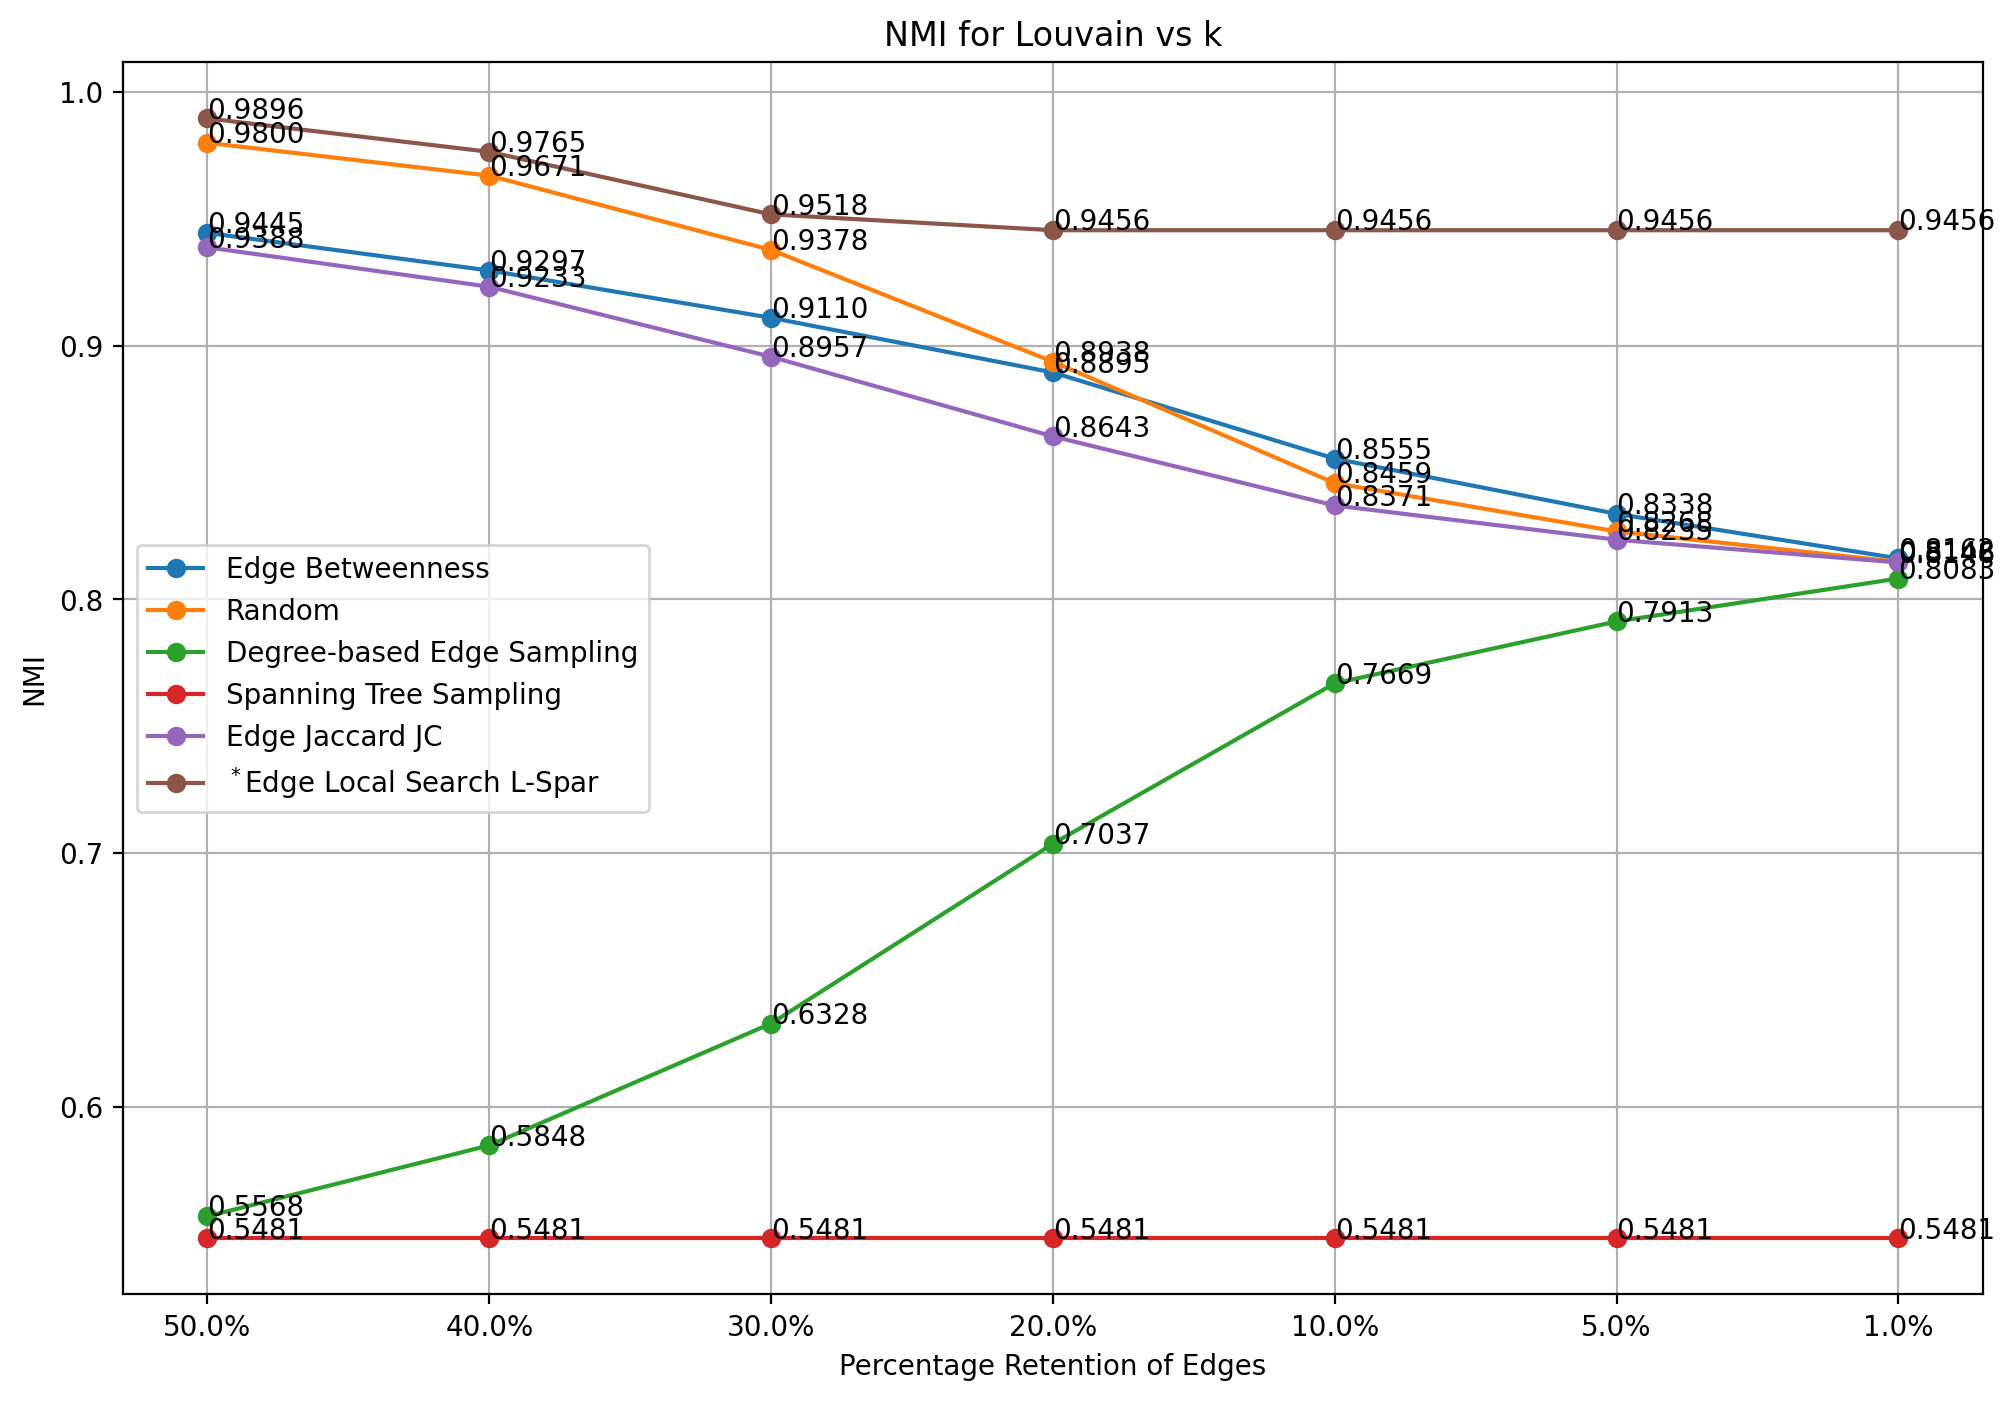

In [24]:
sparseAmzGraphs = plot_metrics_sparse(G_ind_Amz, run_louvain(G_ind_Amz), sparseFunctions, k_values)

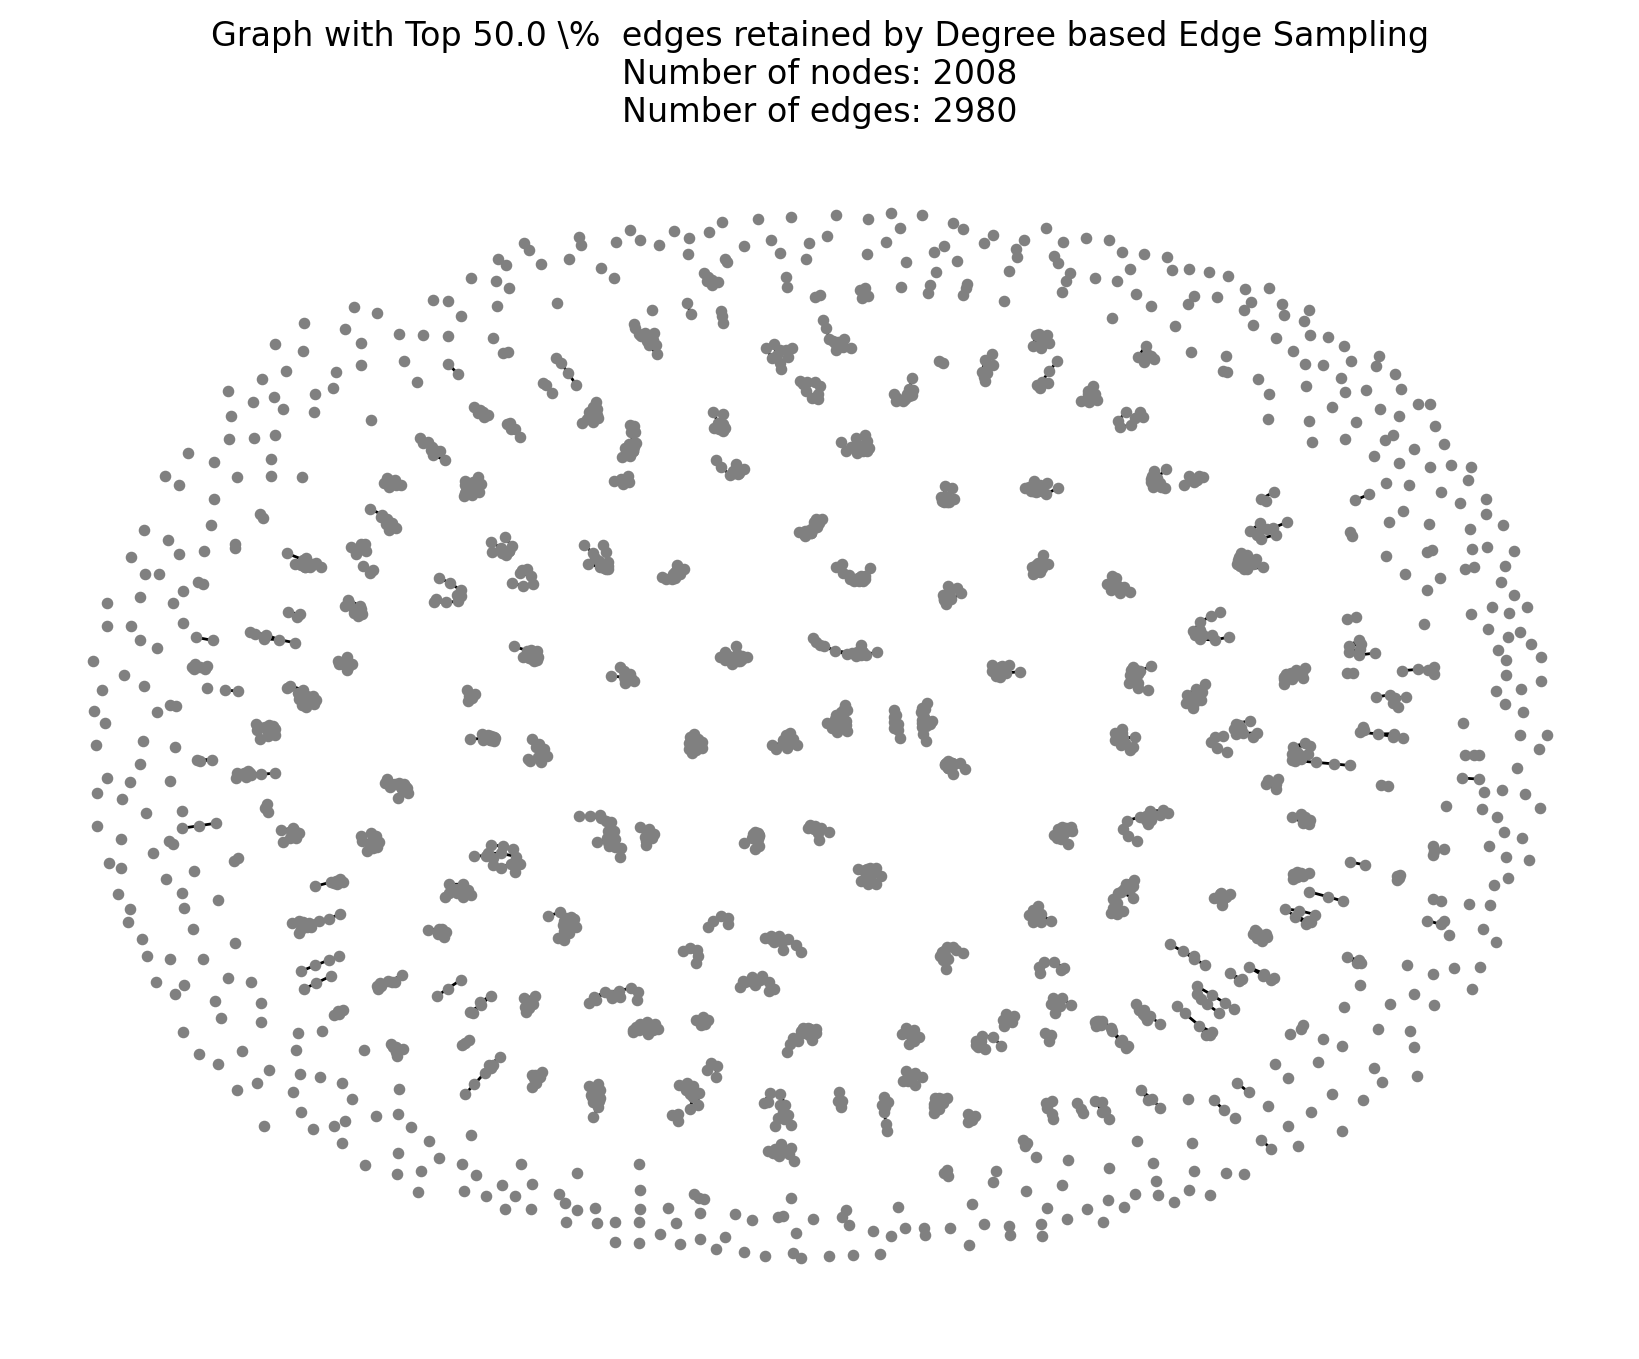

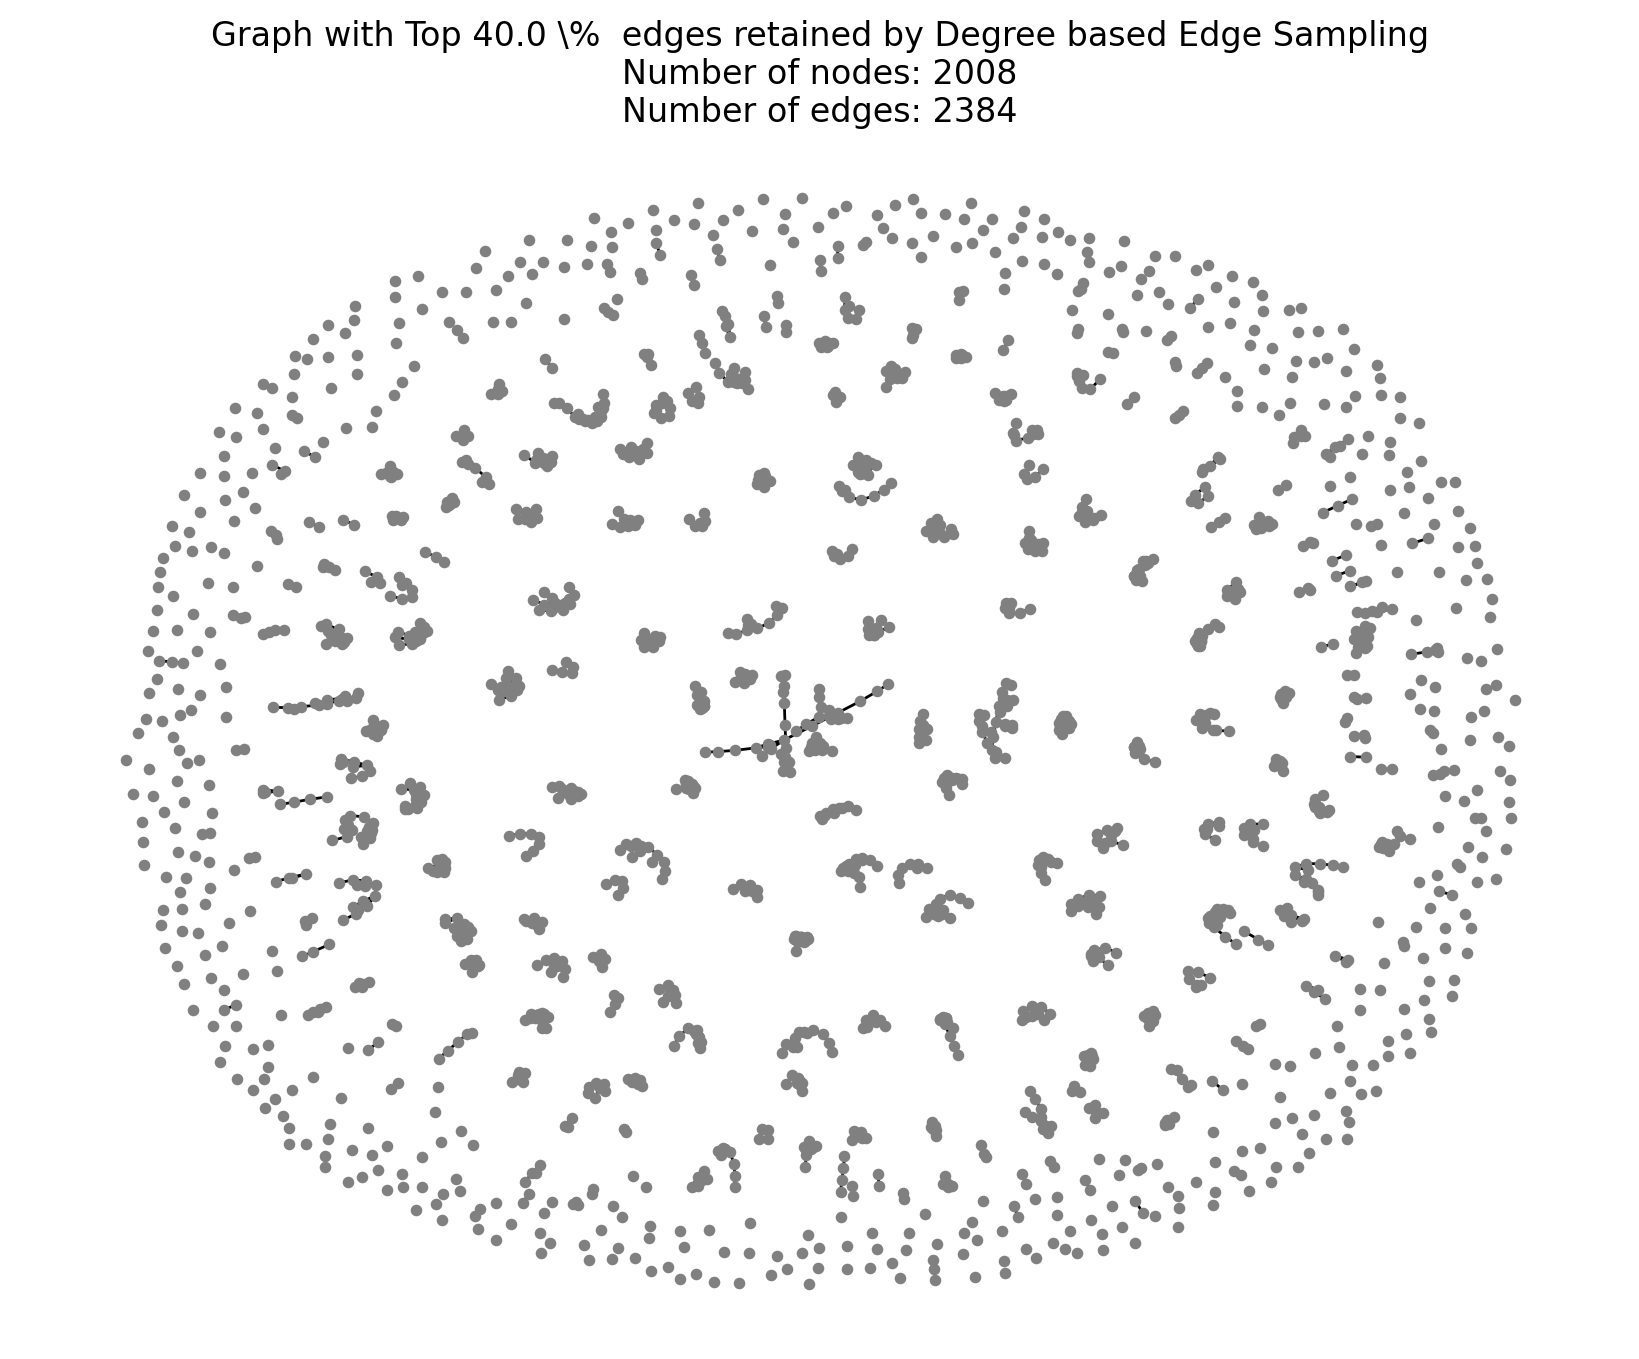

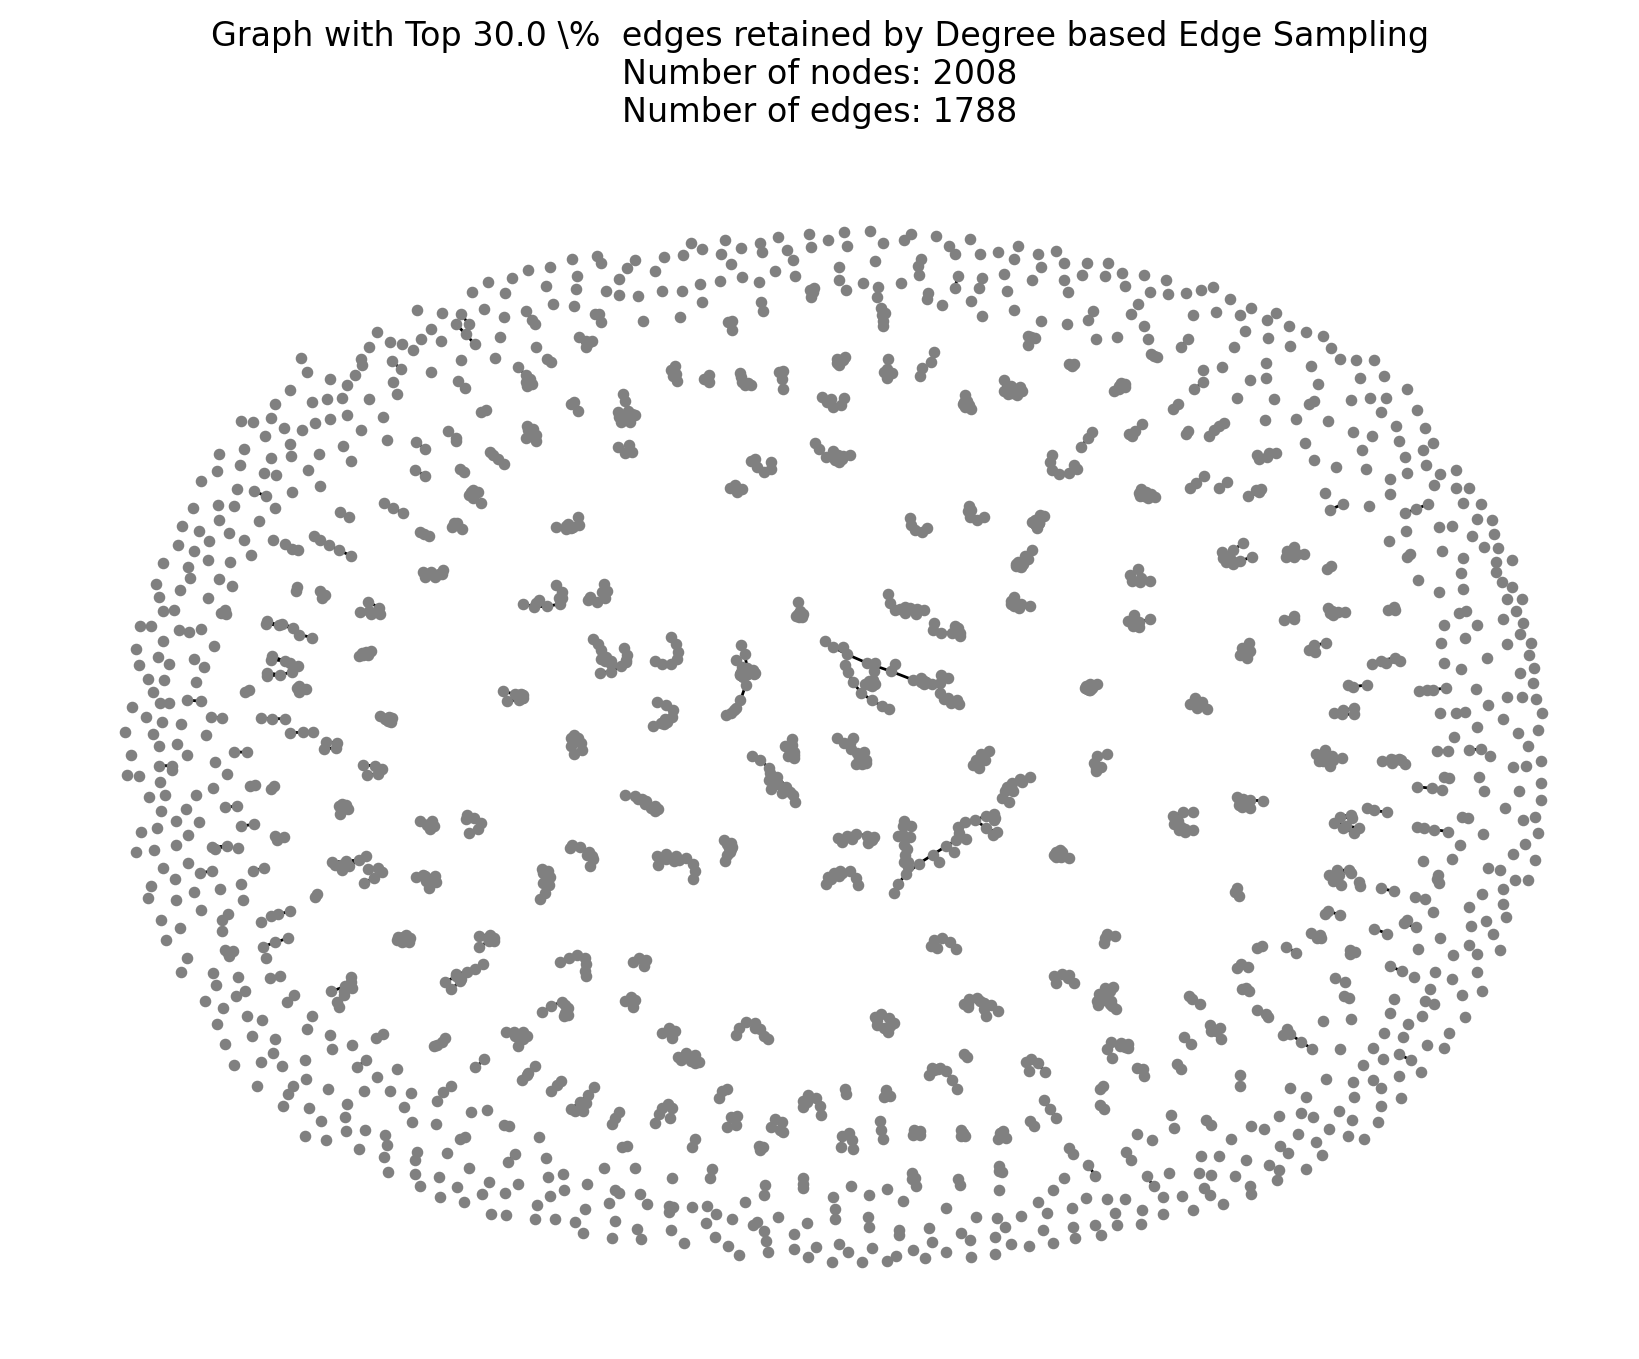

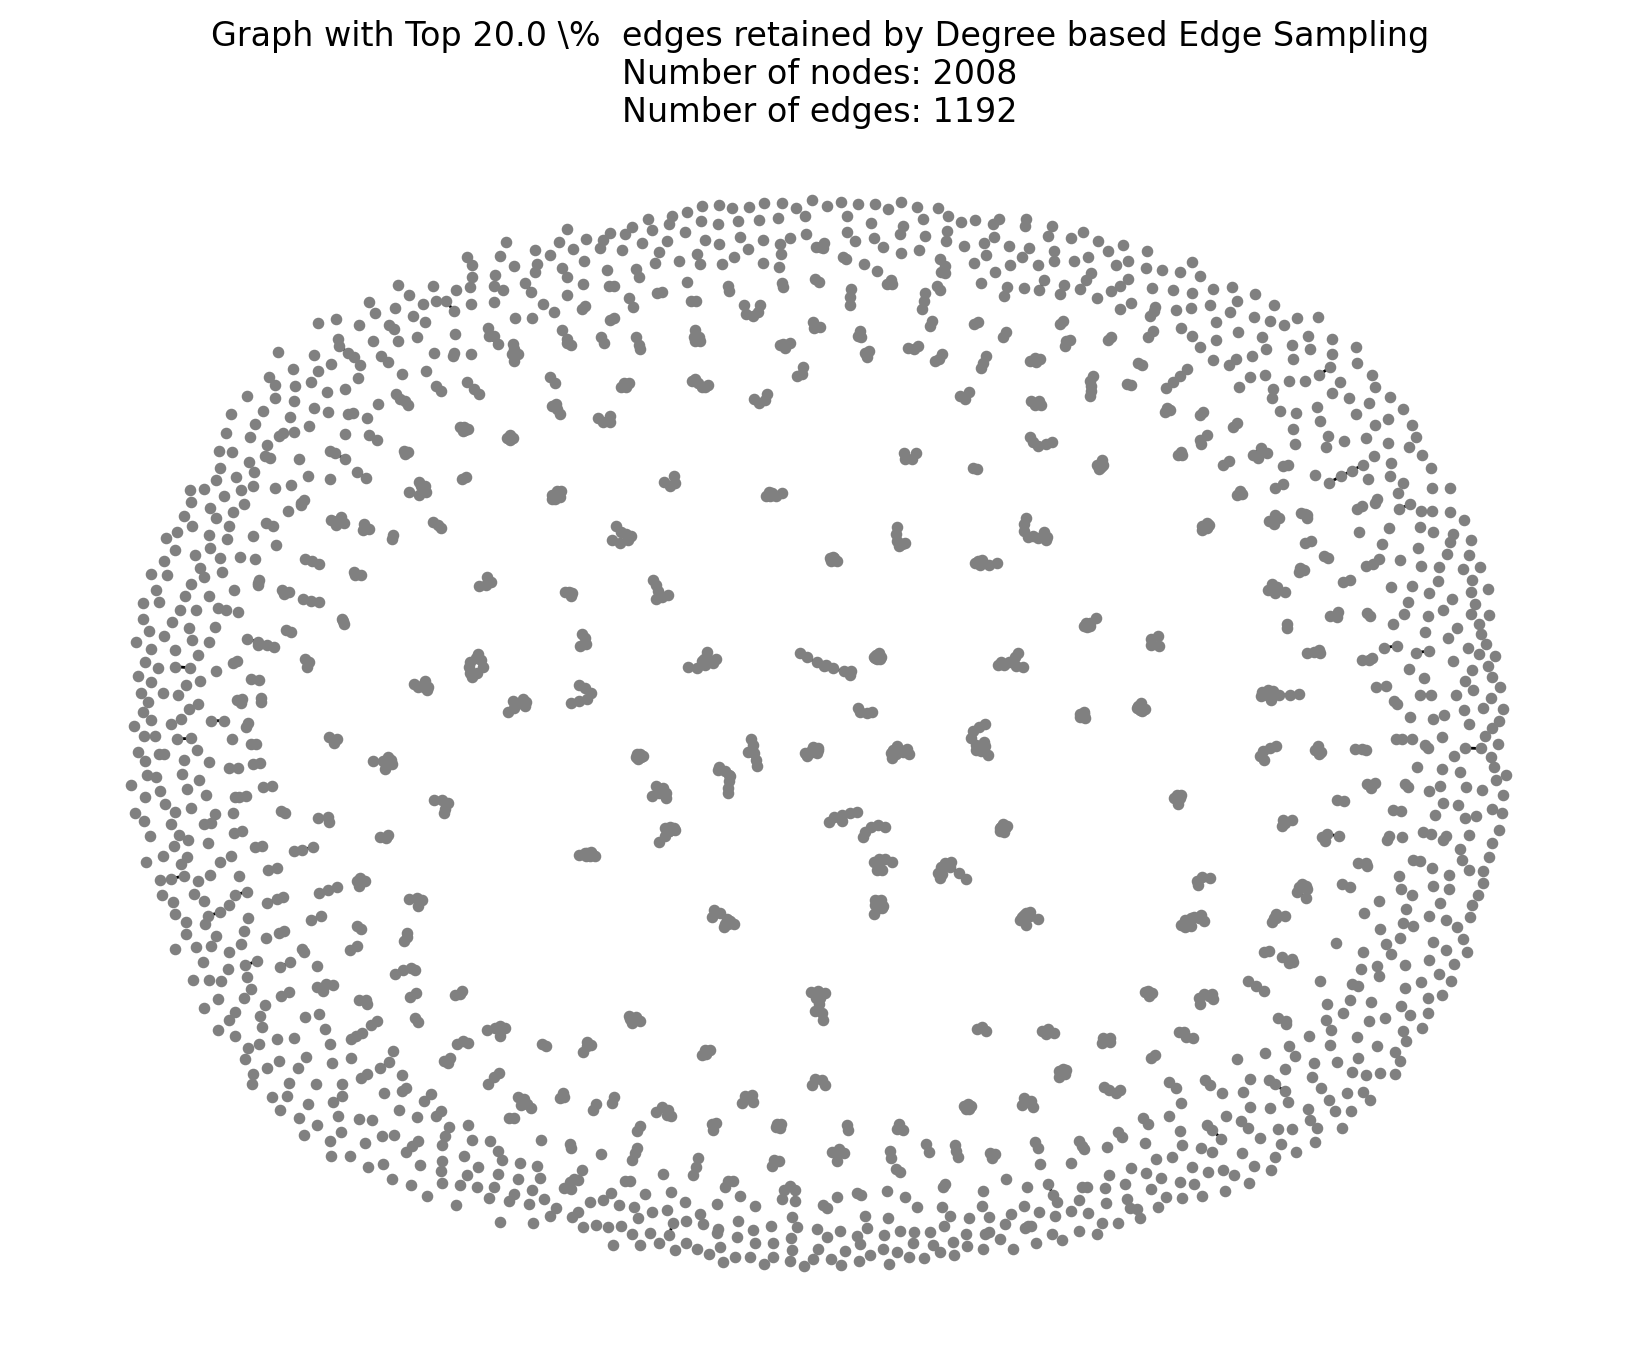

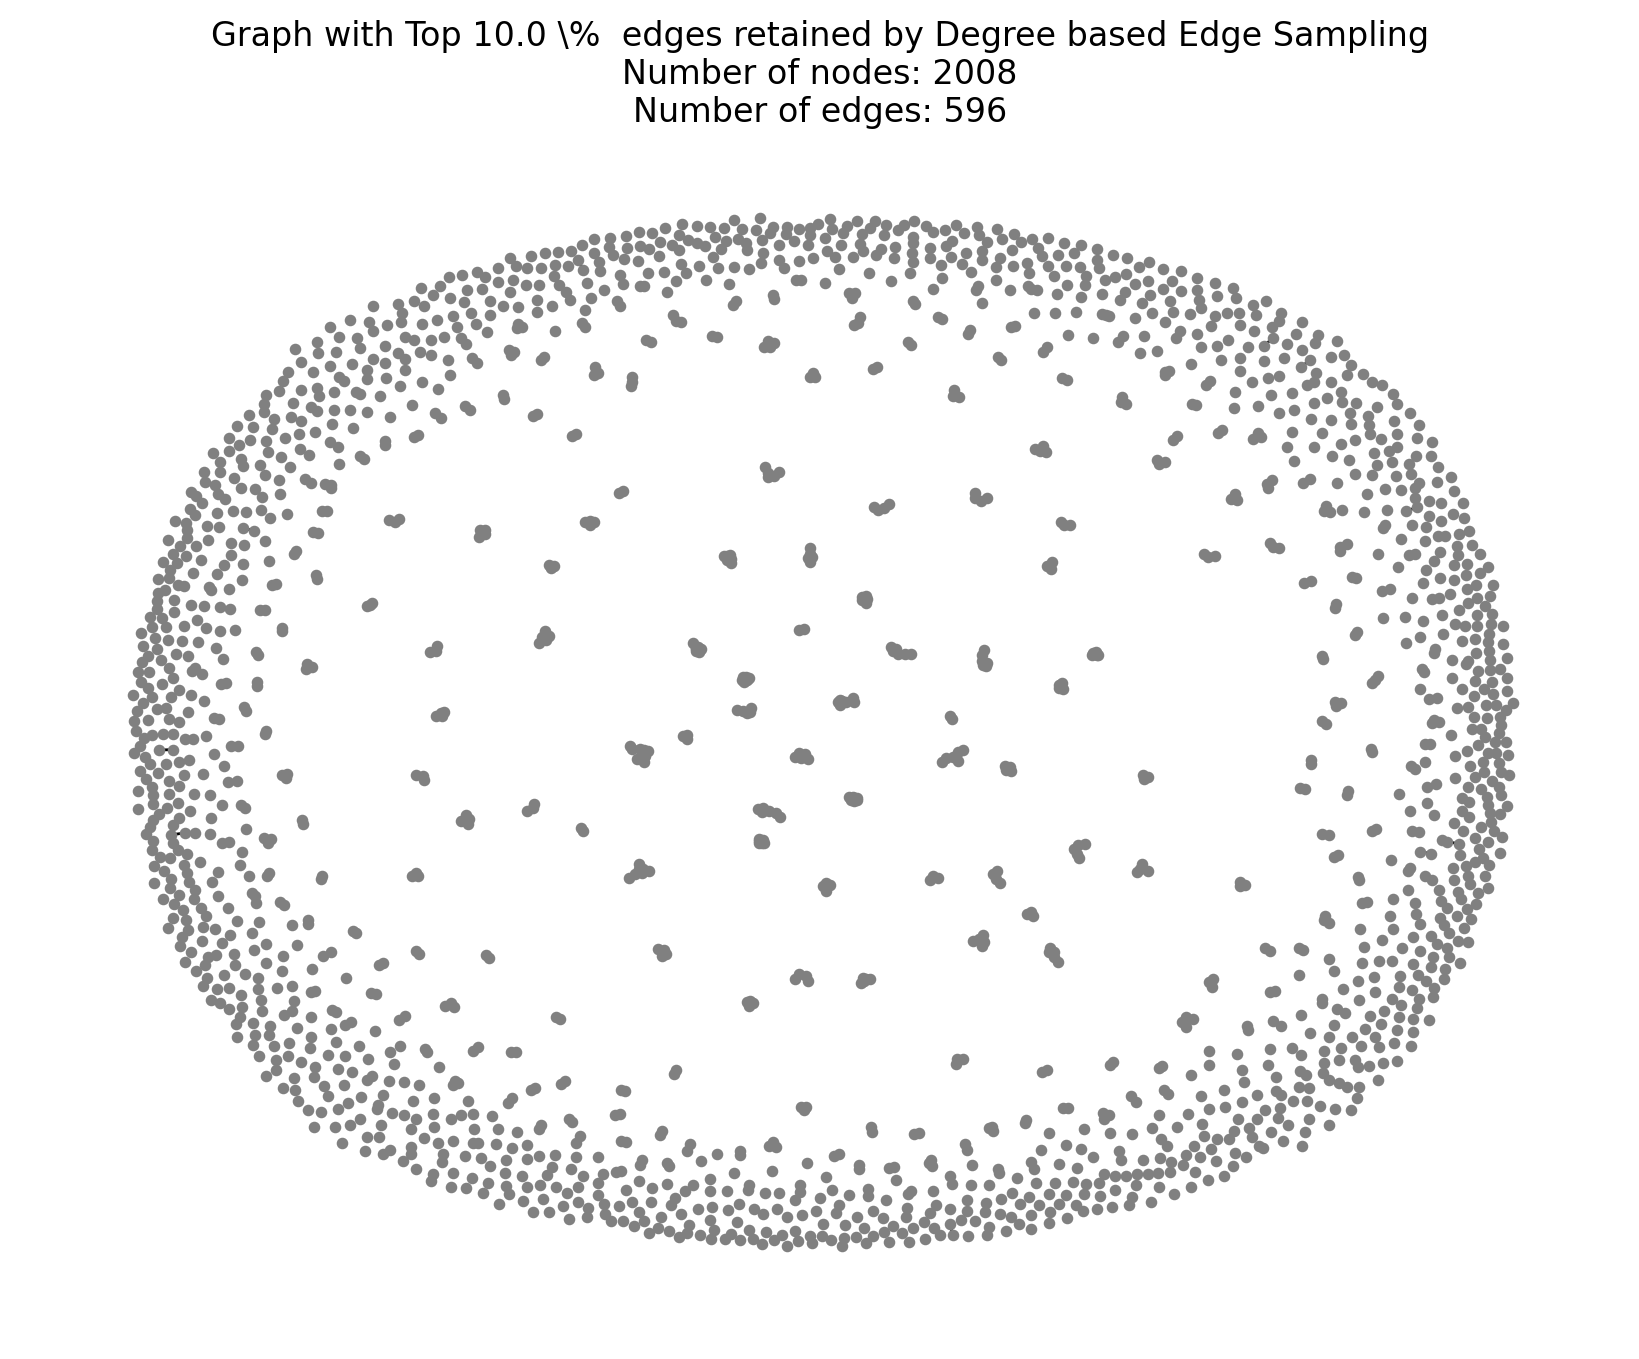

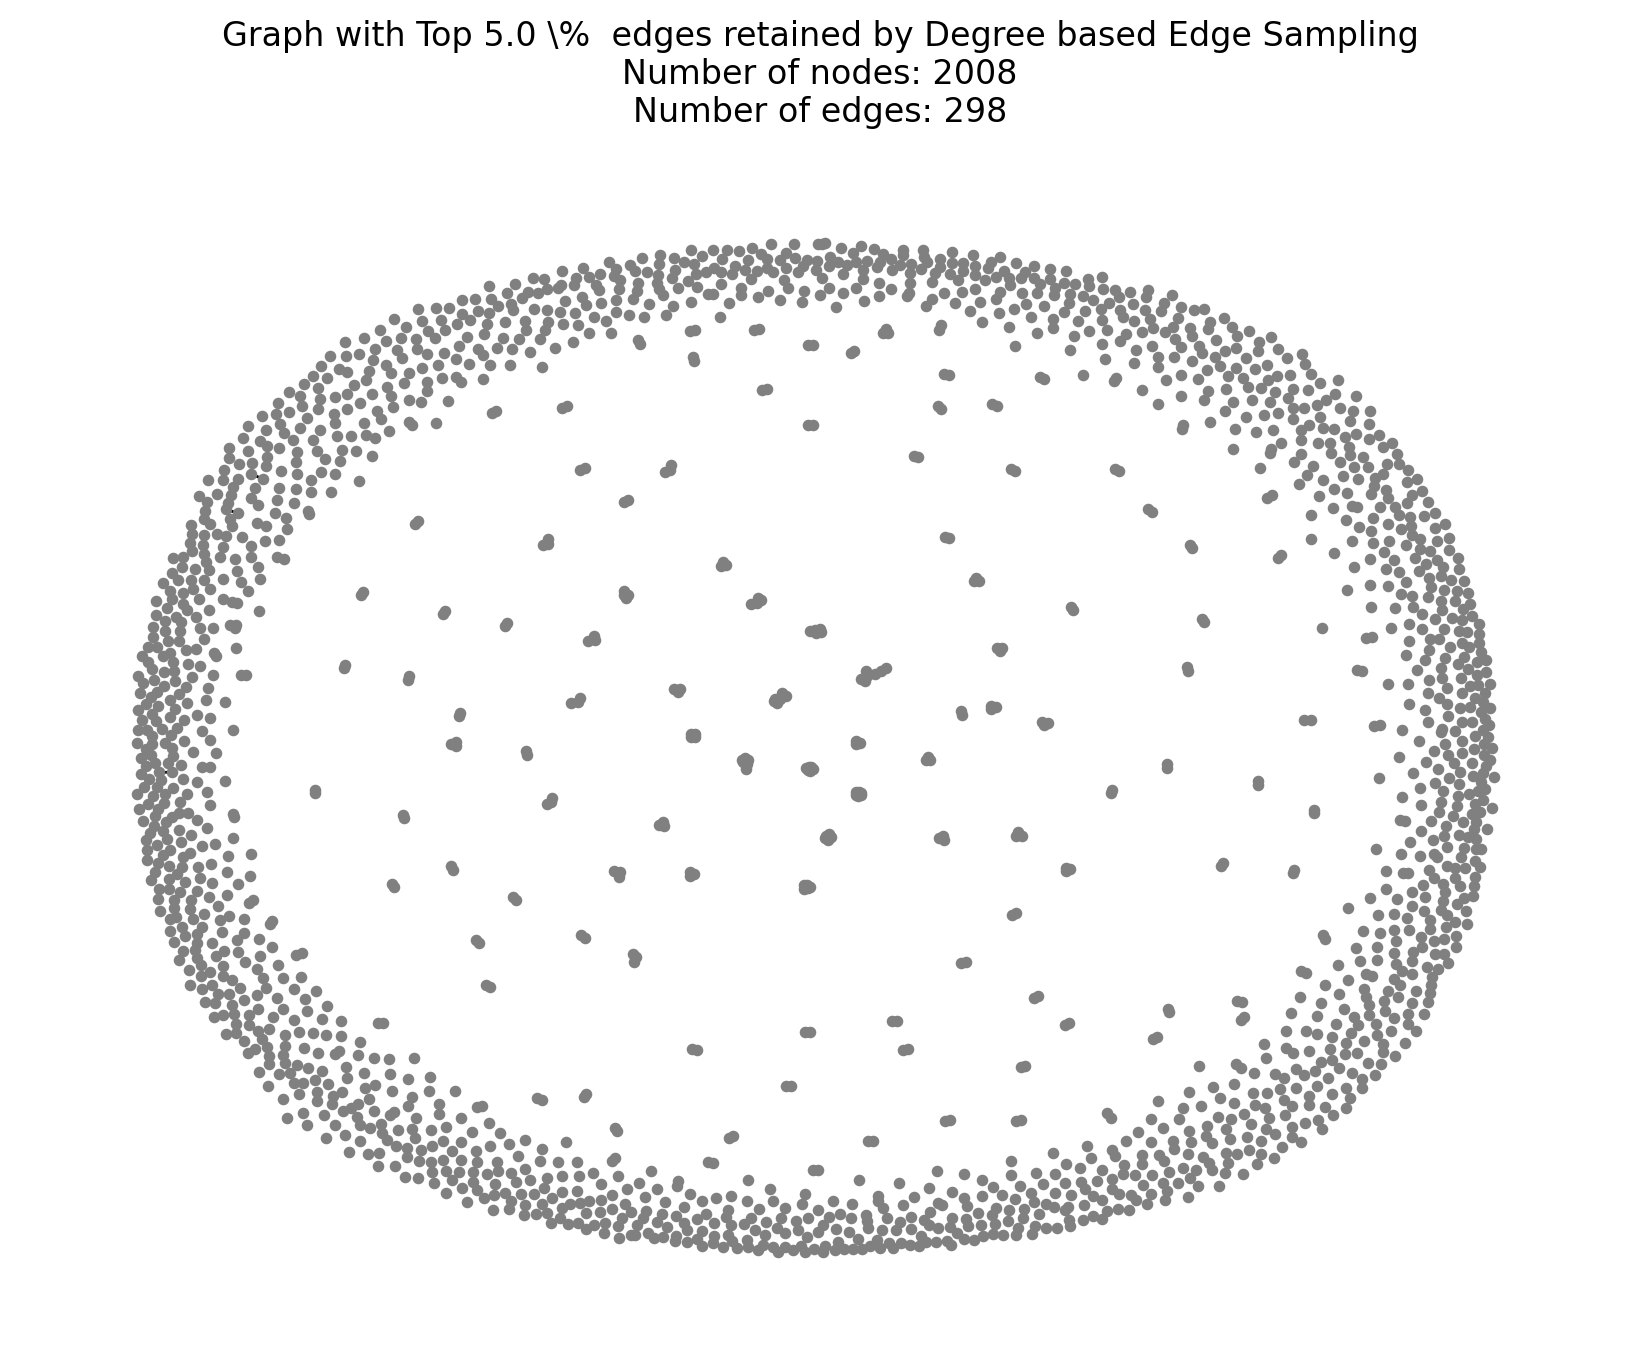

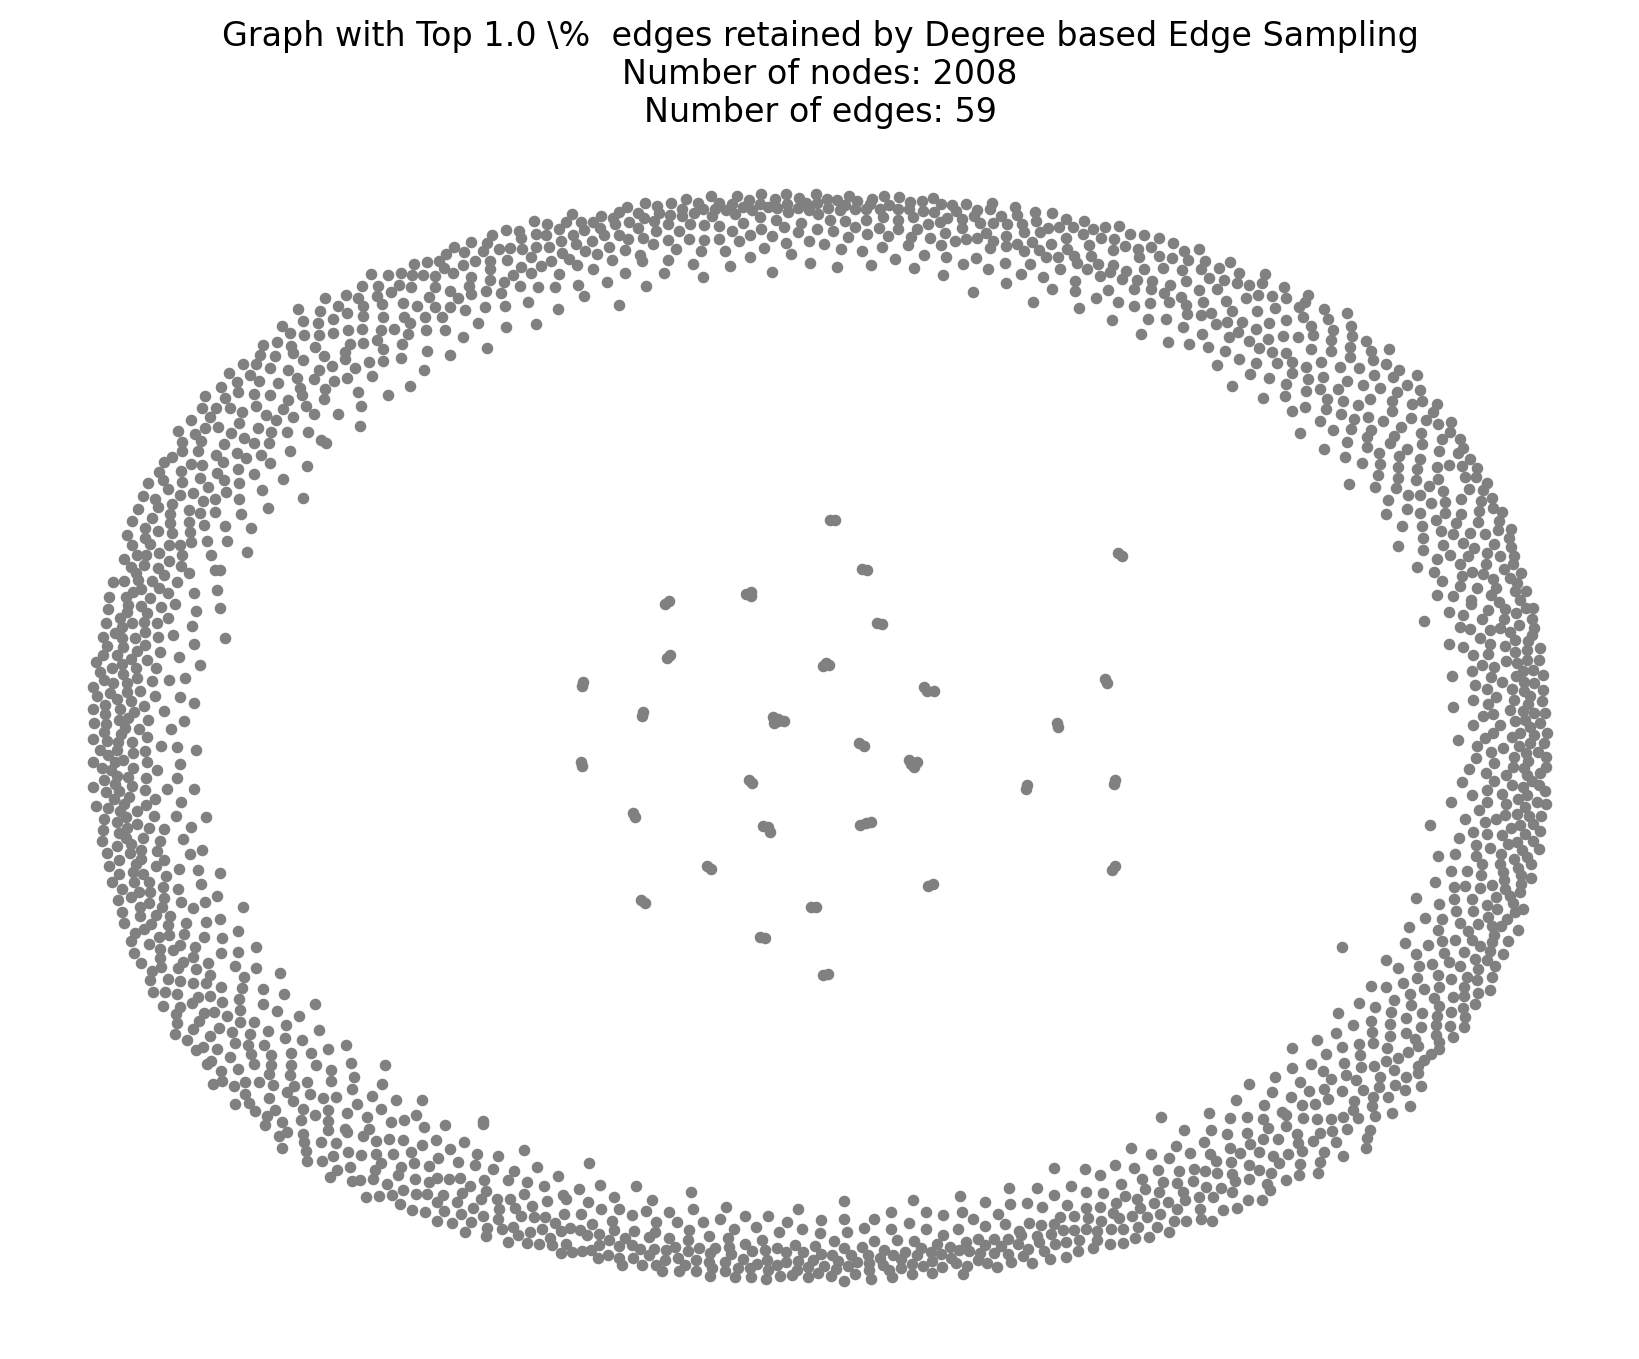

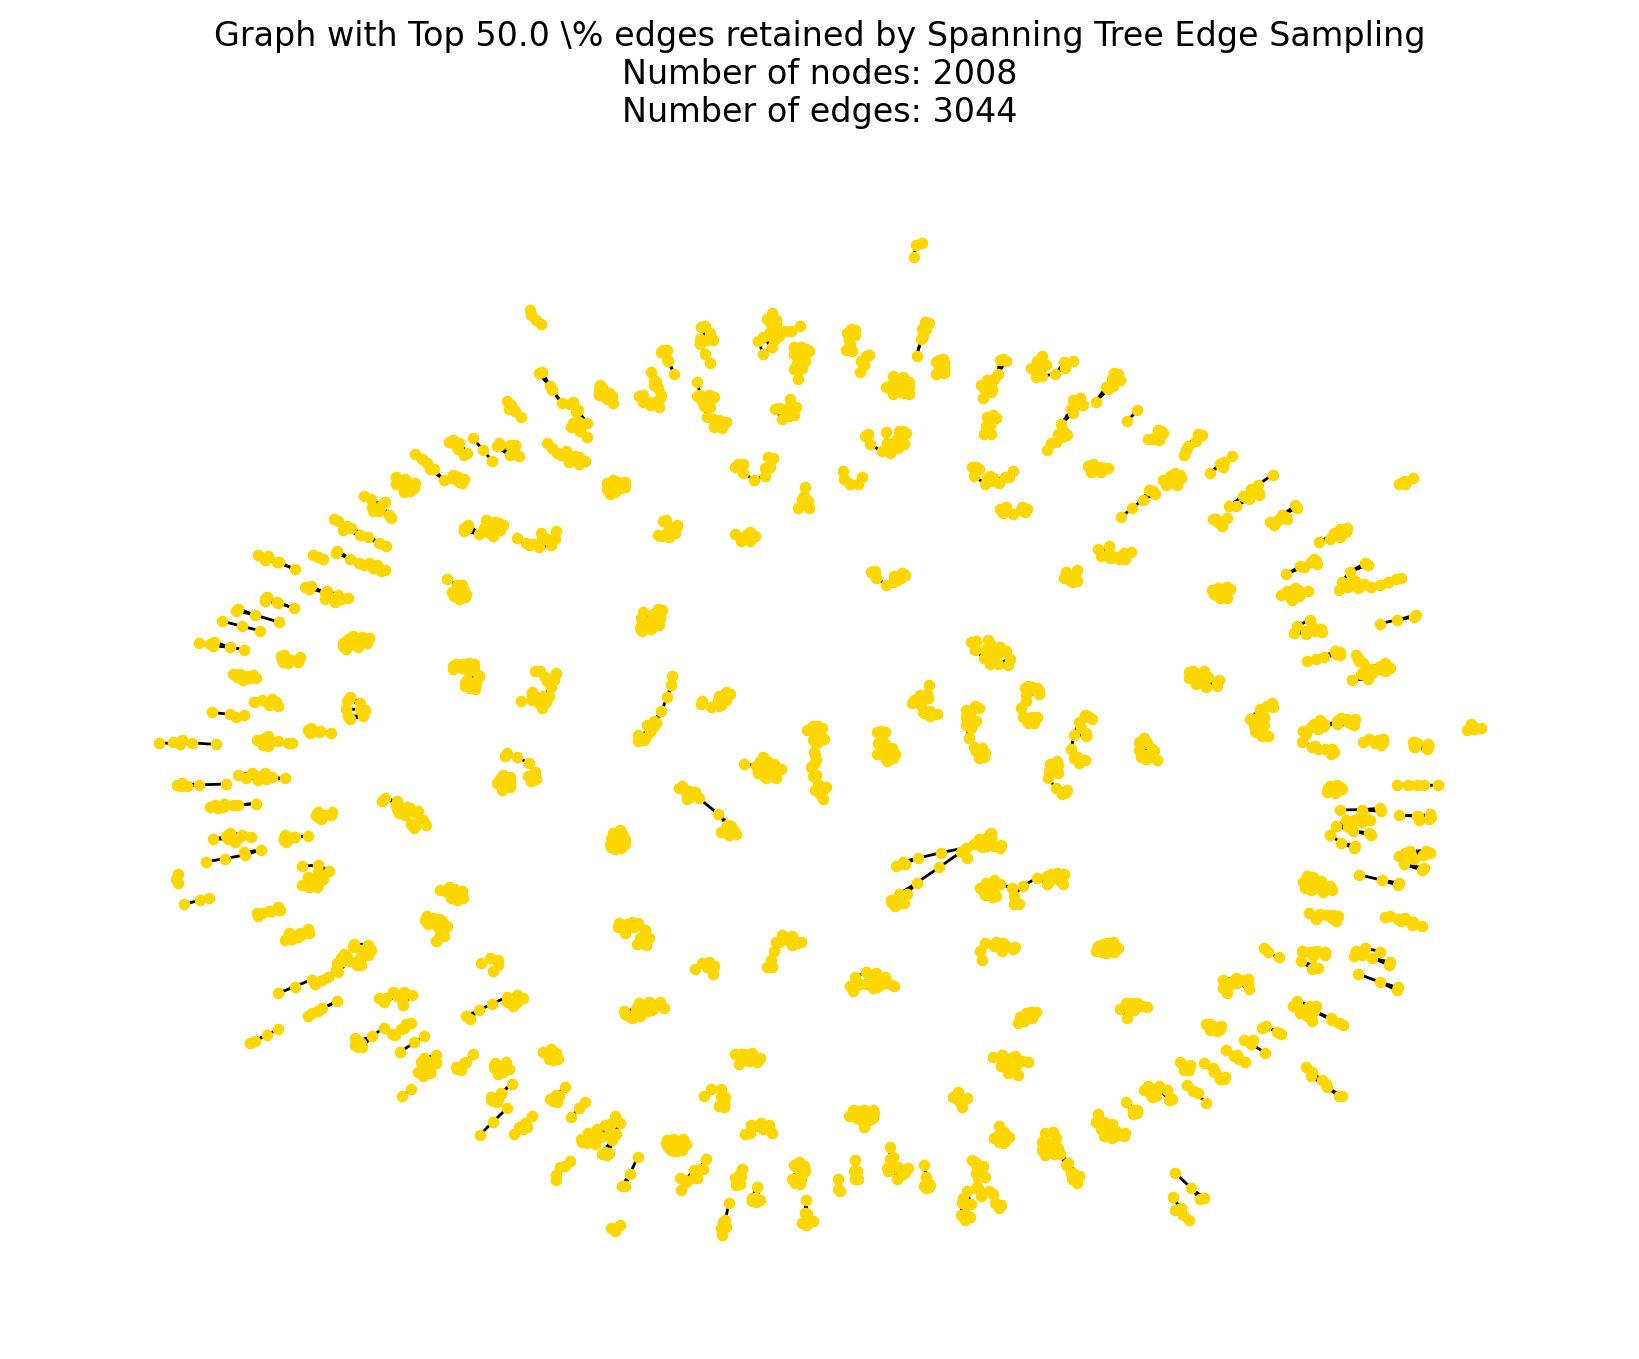

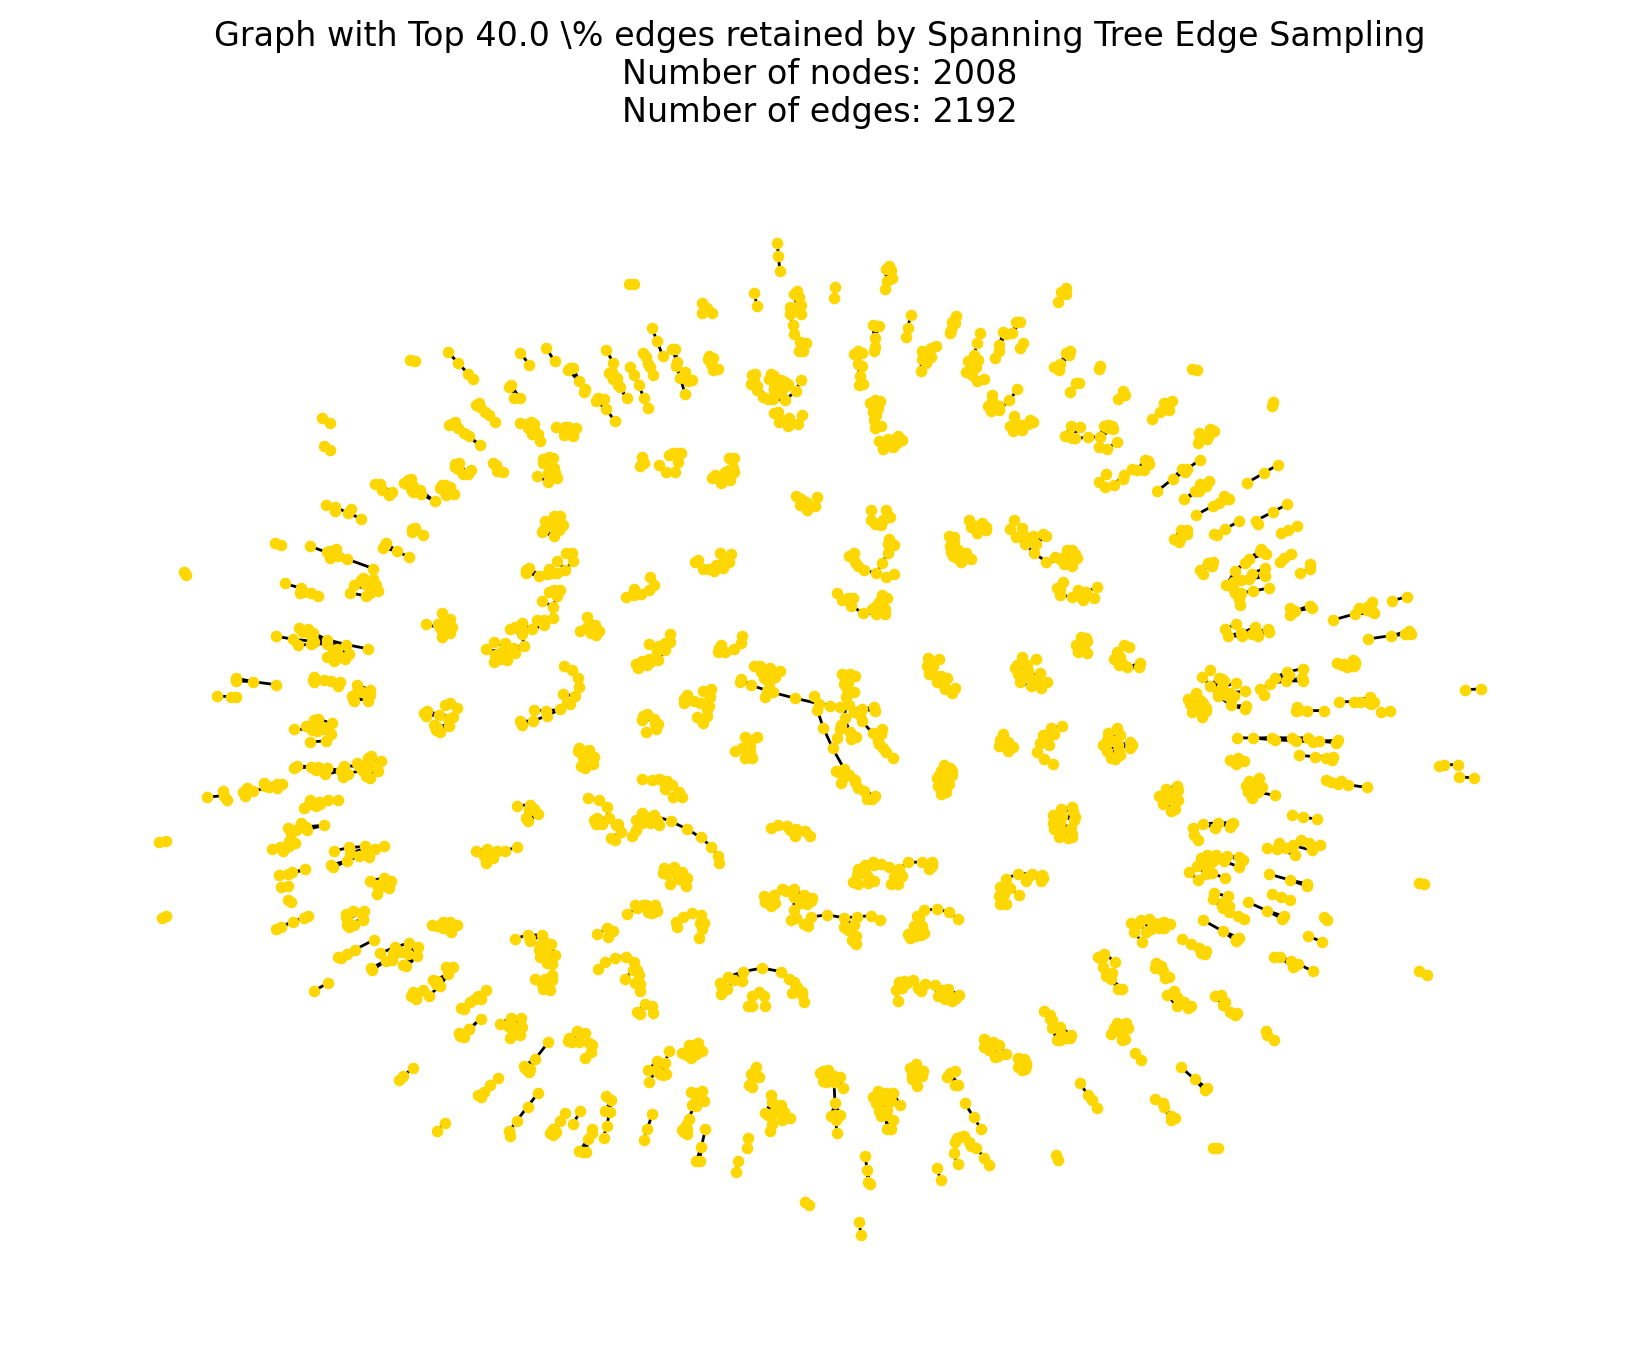

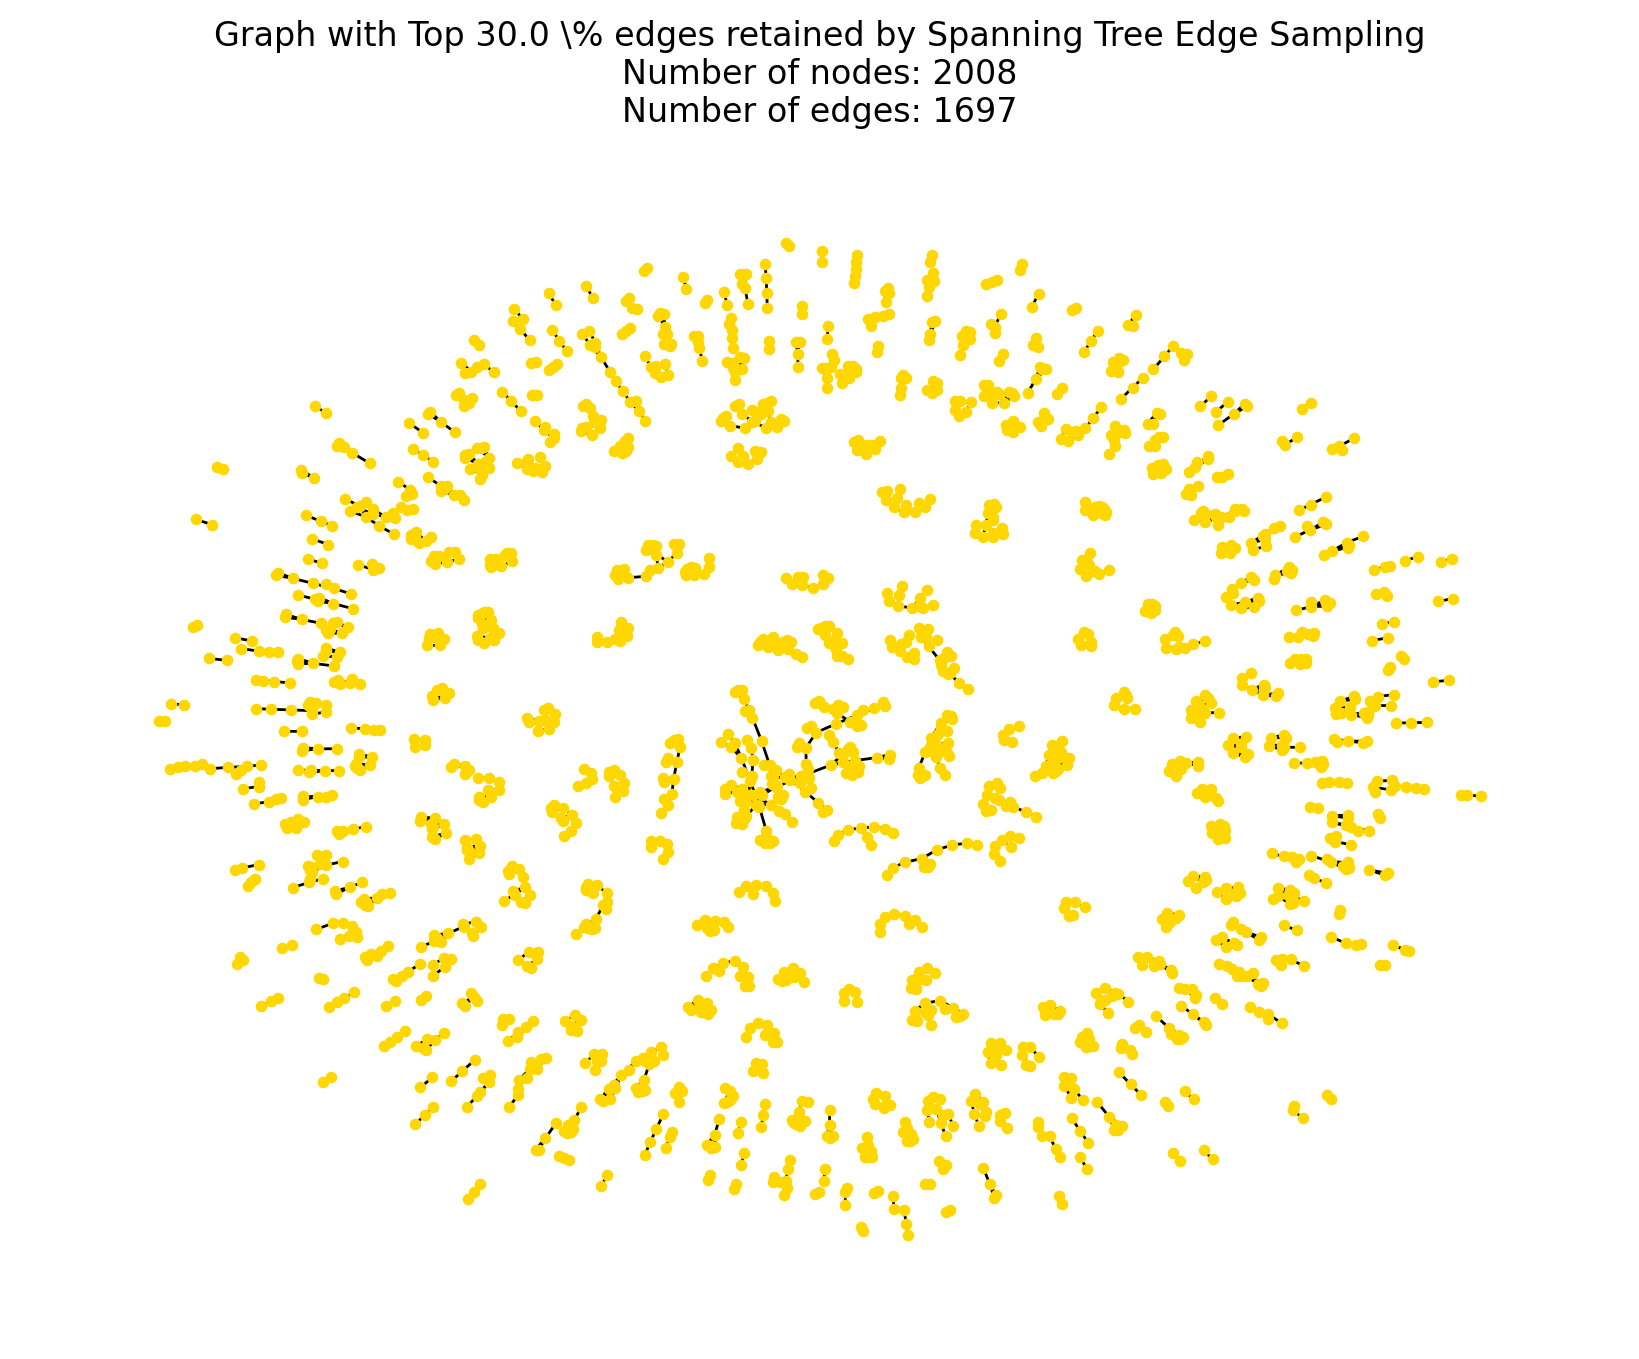

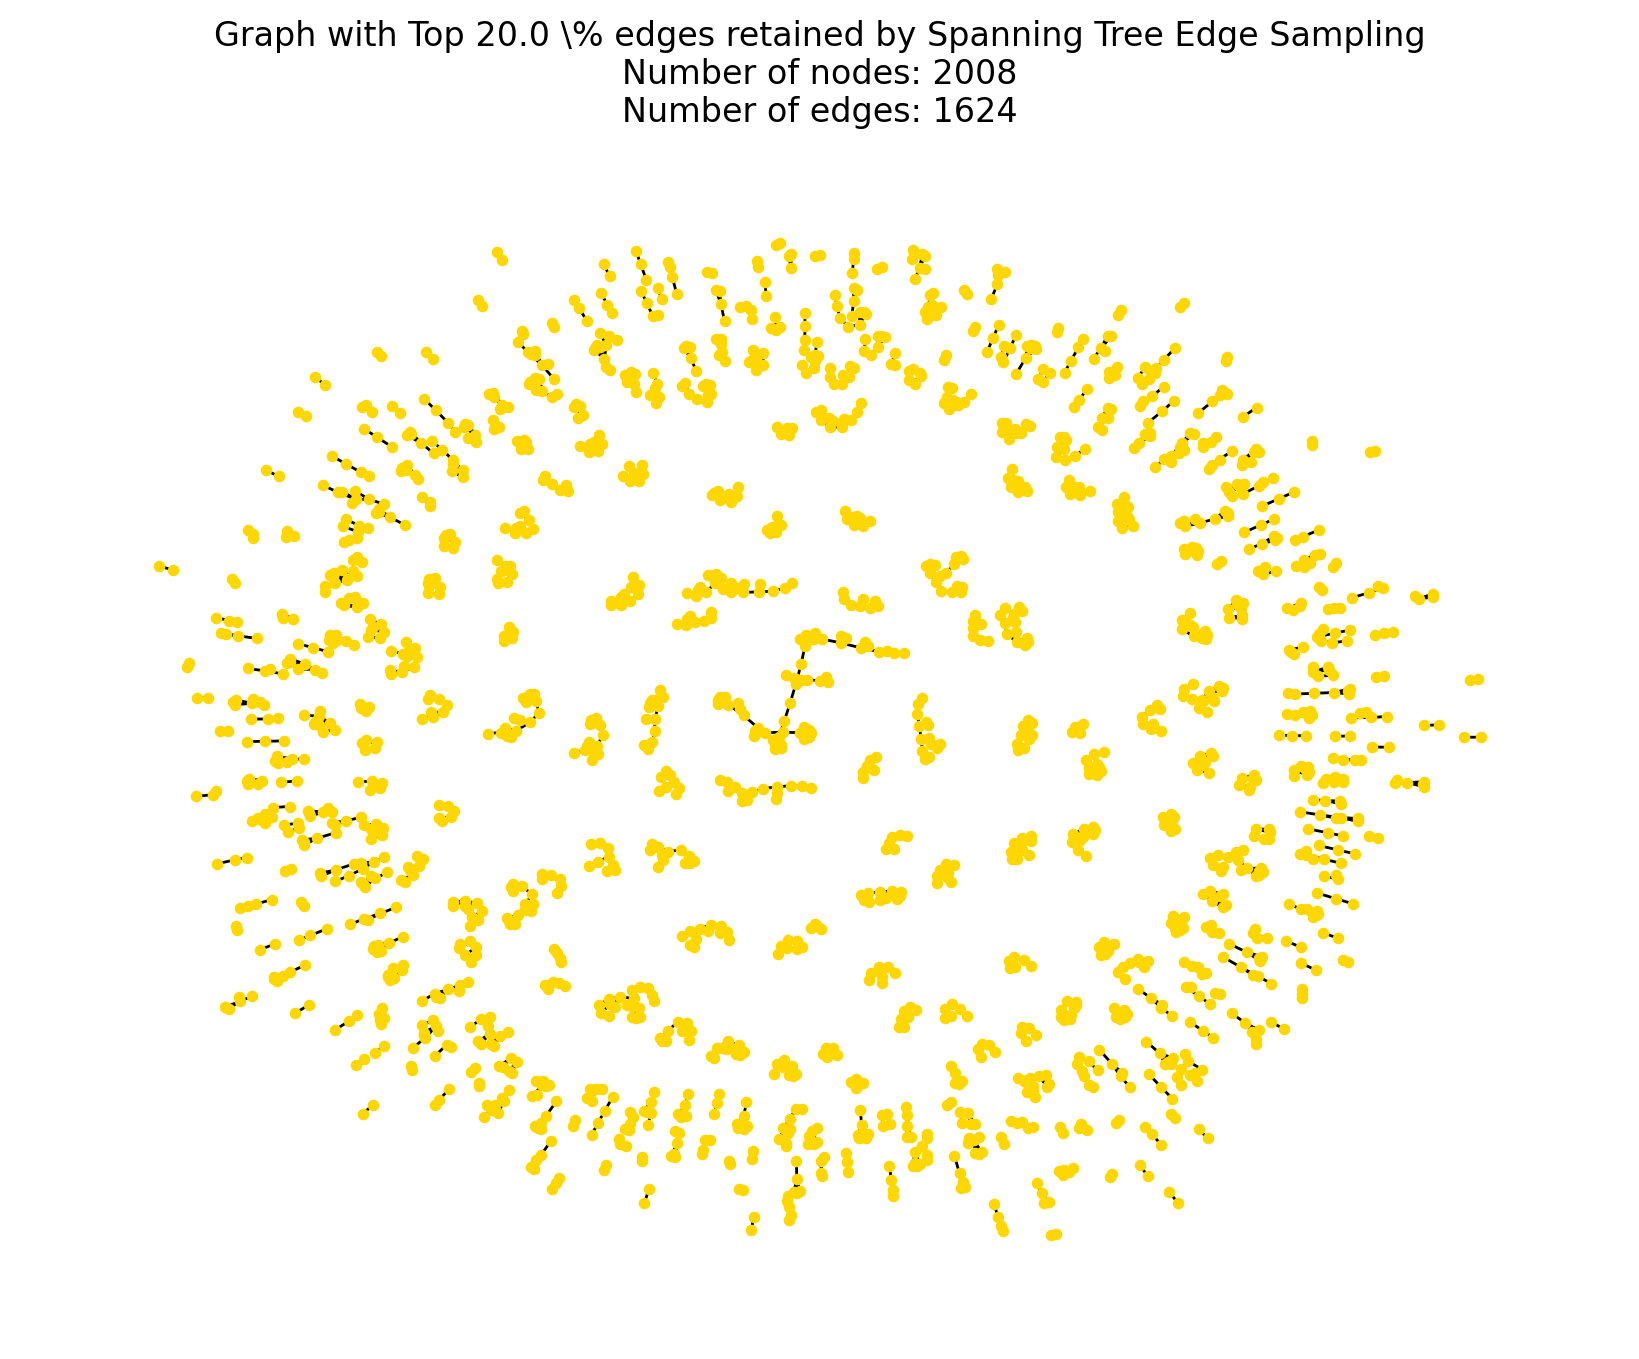

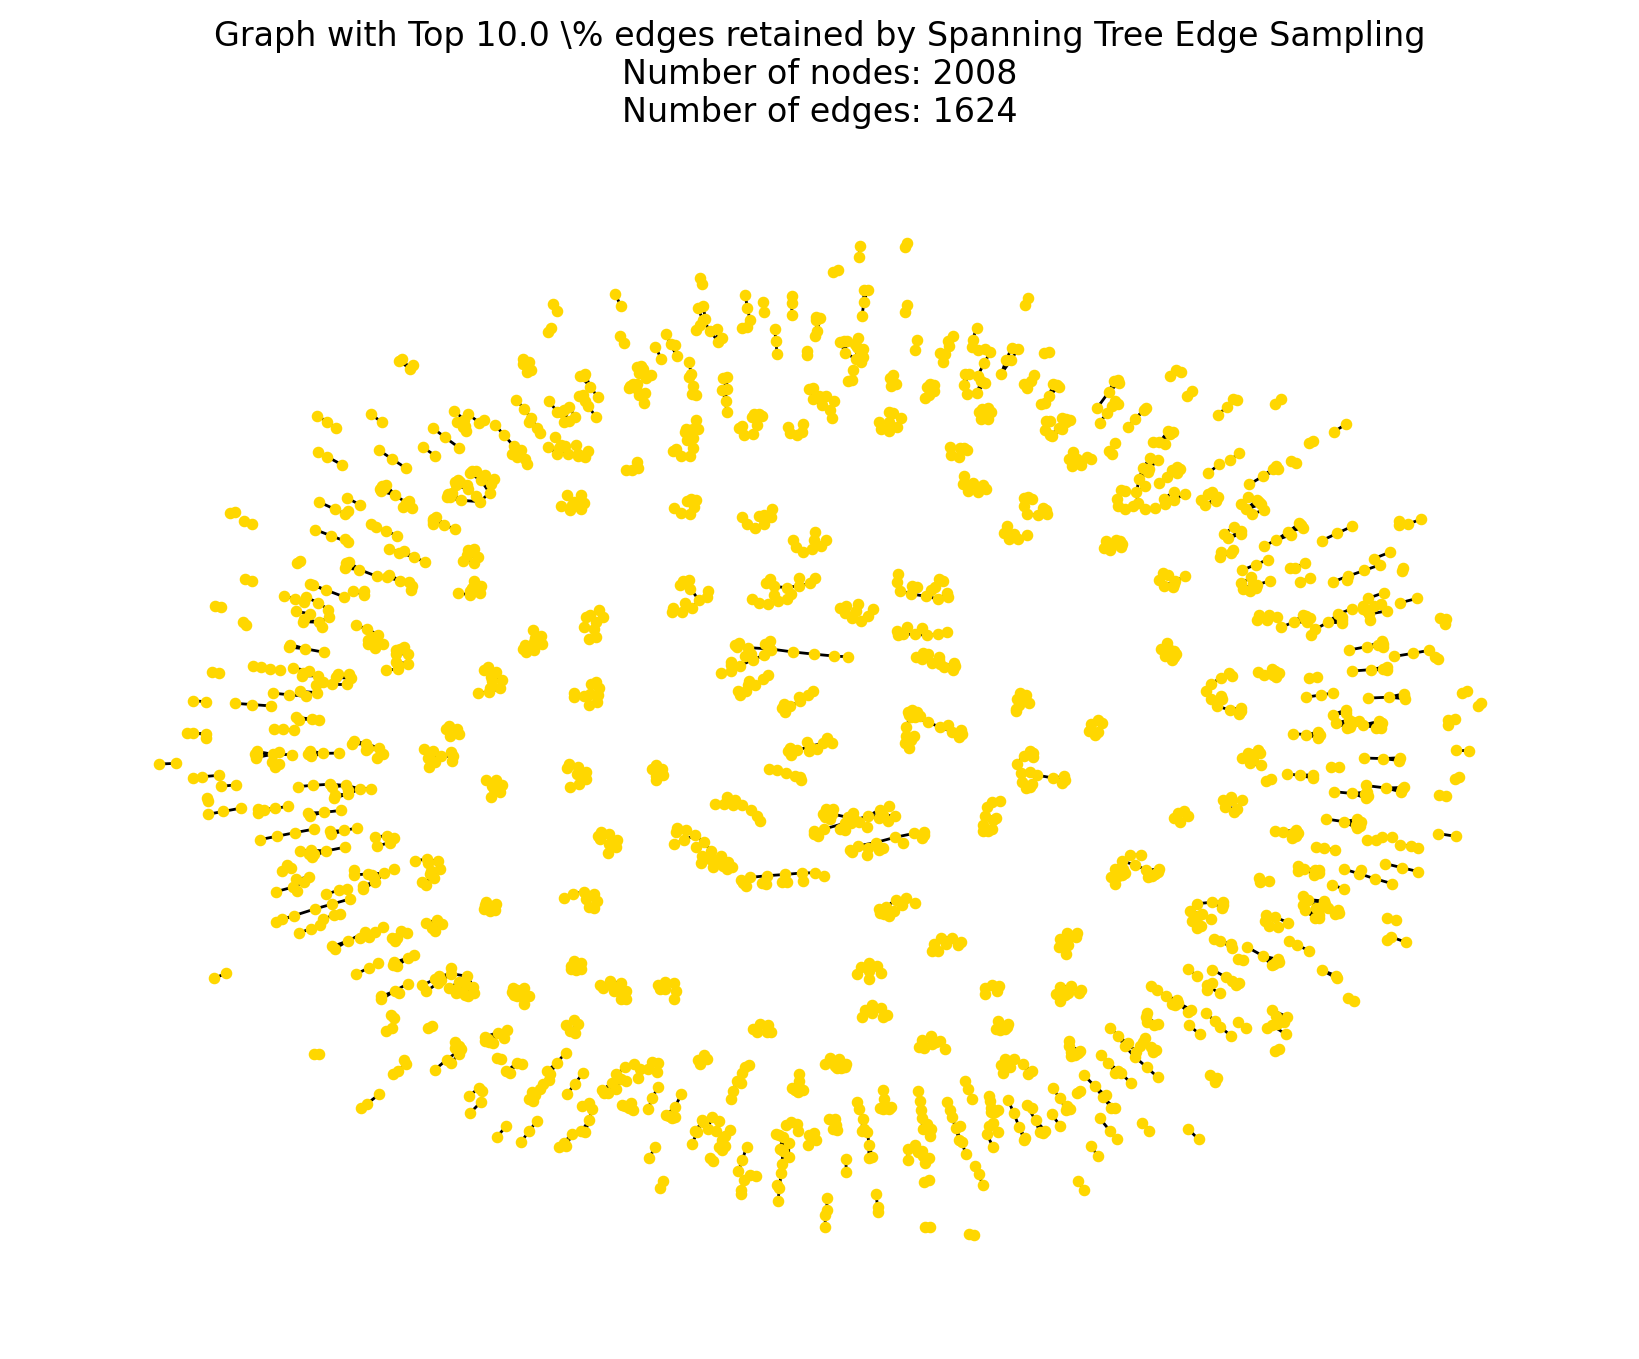

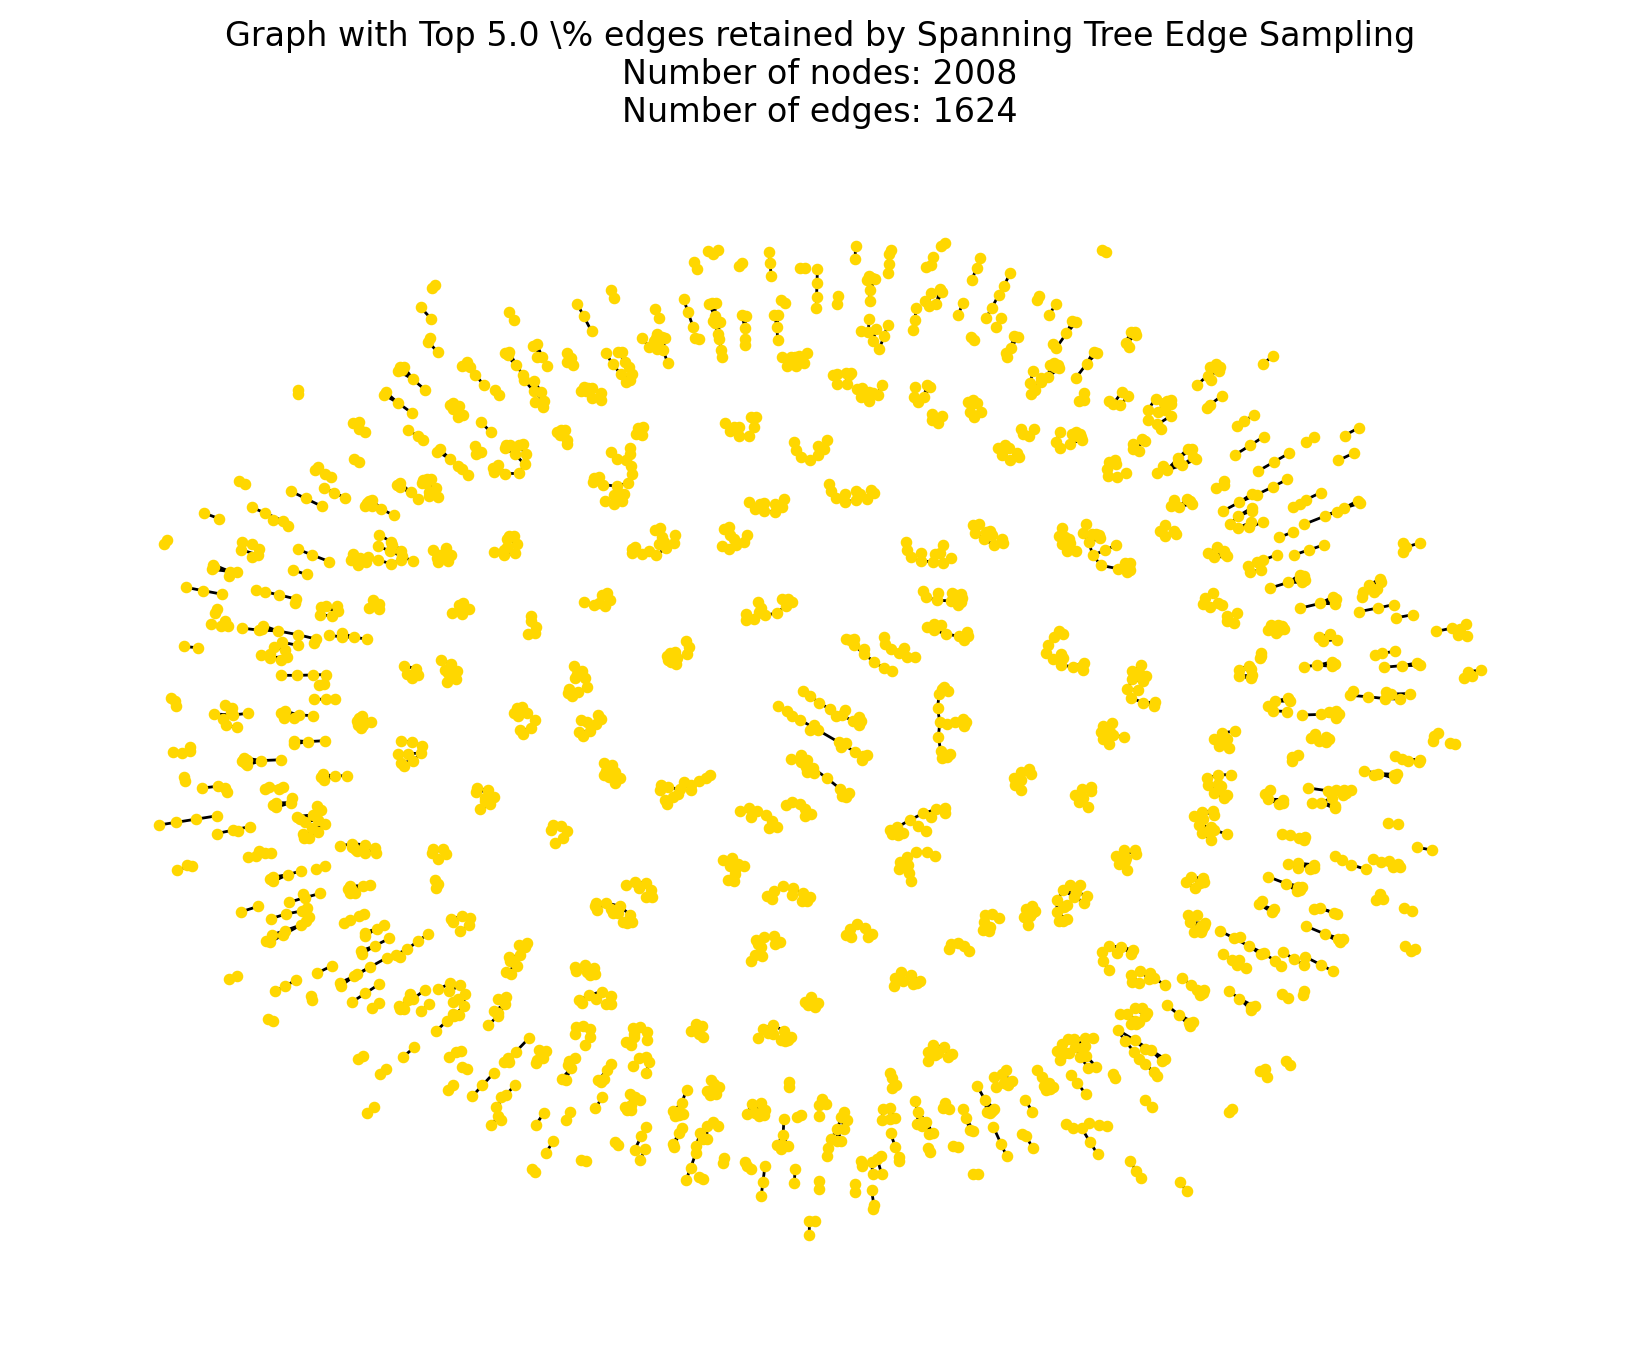

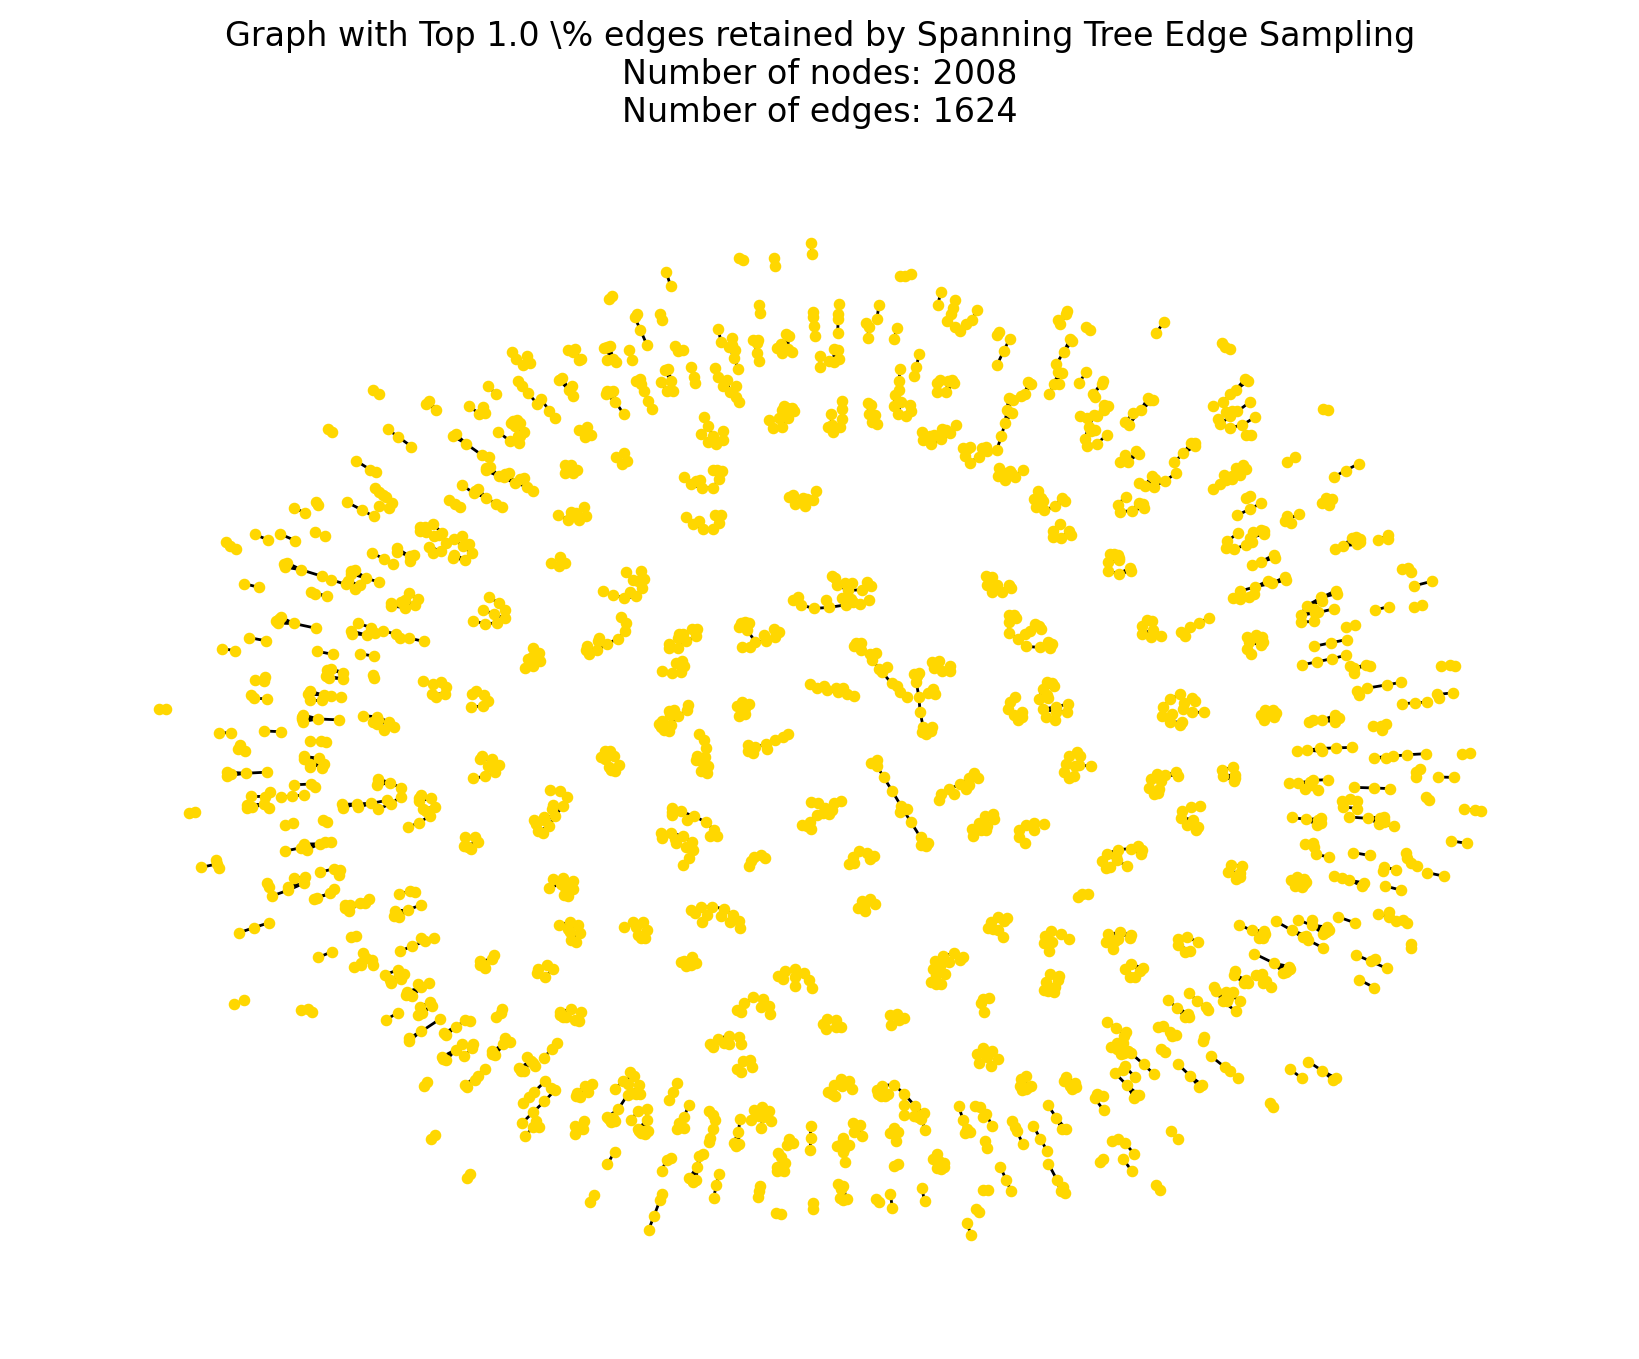

In [25]:
for idx, graph in enumerate(sparseAmzGraphs[4]):
    plt.figure(figsize = (8, 6))
    nx.draw(graph, with_labels = False, node_size = 10, node_color = "gray", edge_color = "black", pos = nx.spring_layout(graph, scale = 4))
    plt.title(fr"Graph with Top {100 * k_values[idx]} %  edges retained by Degree based Edge Sampling" "\n" f"Number of nodes: {graph.number_of_nodes()}" "\n""Number of edges: " f"{graph.number_of_edges()}")
    plt.show()
    
for idx, graph in enumerate(sparseAmzGraphs[5]):
    plt.figure(figsize = (8, 6))
    nx.draw(graph, with_labels = False, node_size = 10, node_color = "gold", edge_color = "black", pos = nx.spring_layout(graph, scale = 4))
    st = str(k_values[idx])
    plt.title(fr"Graph with Top {100 * k_values[idx]} % edges retained by Spanning Tree Edge Sampling" "\n" f"Number of nodes: {graph.number_of_nodes()}" "\n" "Number of edges: " f"{graph.number_of_edges()}")
    plt.show()

## $$ \text{Modularity} $$
### $$ Q(\mathcal{C}) = \frac{1}{2m} \sum_{C \in \mathcal{C}} \sum_{u \in C, v \in C} \left( A_{u, v} - \frac{d_u d_v}{2m} \right) $$

## $$ \text{Betweenness Centrality} $$
### $$ \text{Betweenness}(v) = \sum_{s \neq v,t \neq v} \frac{|\sigma_{s, t}(v)|}{|\sigma_{s, t}|}$$

## $$ \text{Jaccard Similarity} $$
$$ \texttt{An edge (i, j) is likely to lie within a cluster if} $$ 
$$ \text{the vertices i and j have adjancency lists with high overlap} $$

### $$ \text{J}(i, j) = \frac{|\text{Adj}(i) \cap \text{Adj}(j)|}{|\text{Adj}(i) \cup \text{Adj}(j)|} $$